In [1]:
# Libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Load Data
data = pd.read_csv(r'C:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\model\cleaned_data.csv') 
data.head(2) 

CITY  PRICE STATE  COUNTY  ZIPCODE  BEDROOMS   LATITUDE  BATHROOMS  \
0  Austin   1395    TX  Travis    78758         2  30.370937        1.0   
1  Austin   2400    TX  Travis    78741         3  30.223478        2.5   

   LONGITUDE  STATEFIPS  COUNTYFIPS  LISTEDDATE CREATEDDATE LISTINGTYPE  \
0 -97.699005         48         453  2025-12-04  2021-11-16    Standard   
1 -97.699338         48         453  2025-12-02  2021-09-12    Standard   

          ADDRESSLINE1  DAYSONMARKET LASTSEENDATE  PROPERTYTYPE  SQUAREFOOTAGE  
0    1013 Fieldwood Dr            45   2026-01-17  Multi-Family          825.0  
1  6814 E Riverside Dr            47   2026-01-17         Condo         1642.0

In [6]:
data.shape

(23791, 19)

In [28]:
# Ensure ZIPCODE is a string with leading zeros if necessary
data['ZIPCODE'] = data['ZIPCODE'].astype(str).str.zfill(5)

# Convert date columns to datetime format
date_columns = ['LISTEDDATE', 'CREATEDDATE', 'LASTSEENDATE']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # 'coerce' handles invalid parsing

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23791 entries, 0 to 23790
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CITY           23791 non-null  object        
 1   PRICE          23791 non-null  int64         
 2   STATE          23791 non-null  object        
 3   COUNTY         23791 non-null  object        
 4   ZIPCODE        23791 non-null  object        
 5   BEDROOMS       23791 non-null  int64         
 6   LATITUDE       23791 non-null  float64       
 7   BATHROOMS      23791 non-null  float64       
 8   LONGITUDE      23791 non-null  float64       
 9   STATEFIPS      23791 non-null  int64         
 10  COUNTYFIPS     23791 non-null  int64         
 11  LISTEDDATE     23791 non-null  datetime64[ns]
 12  CREATEDDATE    23791 non-null  datetime64[ns]
 13  LISTINGTYPE    23791 non-null  object        
 14  ADDRESSLINE1   23791 non-null  object        
 15  DAYSONMARKET   2379

**EDA 1: UNIVARIATE EXPLORATORY DATA ANALYSIS**

**CATEGORICAL COLUMNS VALUE COUNTS**

In [29]:
# List all object/category columns
obj_cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Object/Category columns ({len(obj_cat_cols)}):")
print(obj_cat_cols)

Object/Category columns (7):
['CITY', 'STATE', 'COUNTY', 'ZIPCODE', 'LISTINGTYPE', 'ADDRESSLINE1', 'PROPERTYTYPE']


In [30]:
# Check value counts for specific categorical columns
cols_to_check = ["LISTINGTYPE", "PROPERTYTYPE", "CITY", "COUNTY", "ZIPCODE", "STATE"]

print("\nDataset: data")
for col in [c for c in cols_to_check if c in data.columns and data[c].dtype in ["object", "category"]]:
    print(f"\n{col}")
    print(data[col].value_counts(dropna=False))
    print("-" * 50)



Dataset: data

LISTINGTYPE
LISTINGTYPE
Standard            23673
New Construction      118
Name: count, dtype: int64
--------------------------------------------------

PROPERTYTYPE
PROPERTYTYPE
Apartment        11155
Single Family     8067
Condo             2787
Townhouse         1311
Multi-Family       455
Manufactured        16
Name: count, dtype: int64
--------------------------------------------------

CITY
CITY
Portland                         526
New Orleans                      499
Austin                           495
Albuquerque                      491
Baltimore                        490
Louisville                       487
Philadelphia                     485
Omaha                            471
Indianapolis                     470
Chicago                          446
New York                         445
Memphis                          429
Atlanta                          419
Sioux Falls                      412
Denver                           395
Boston                 

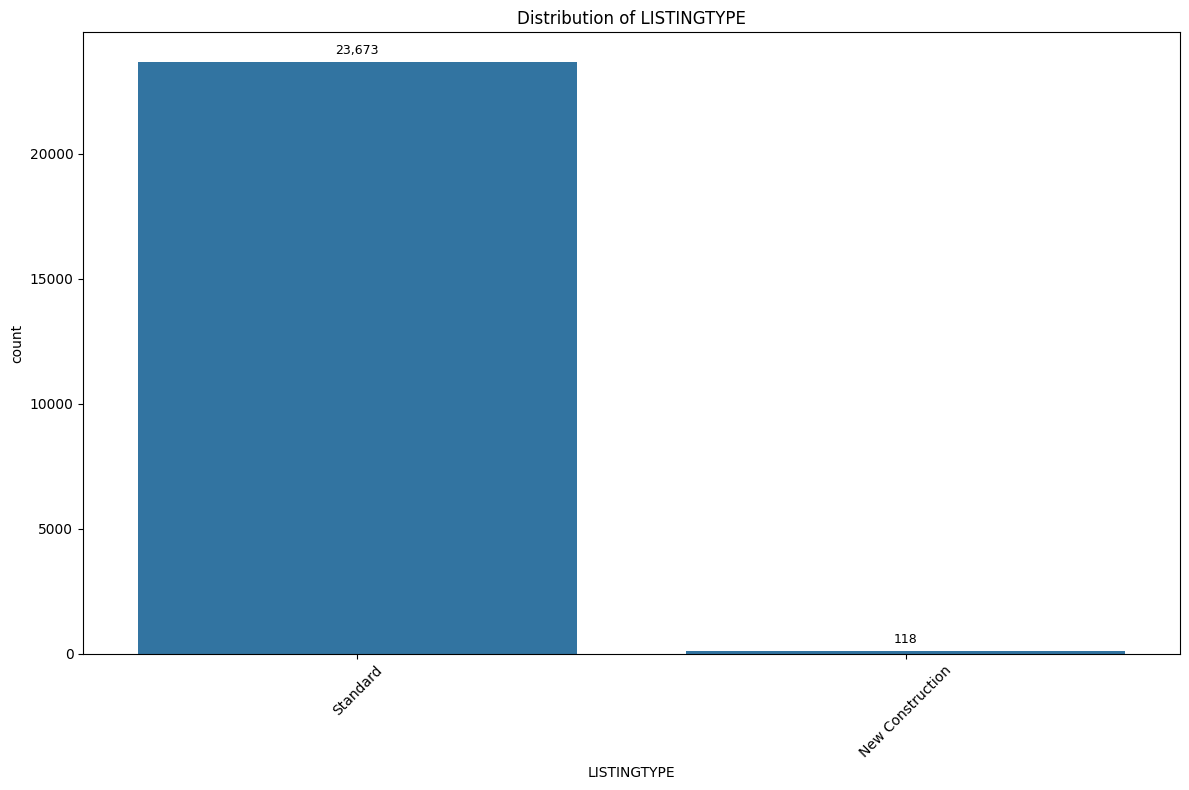

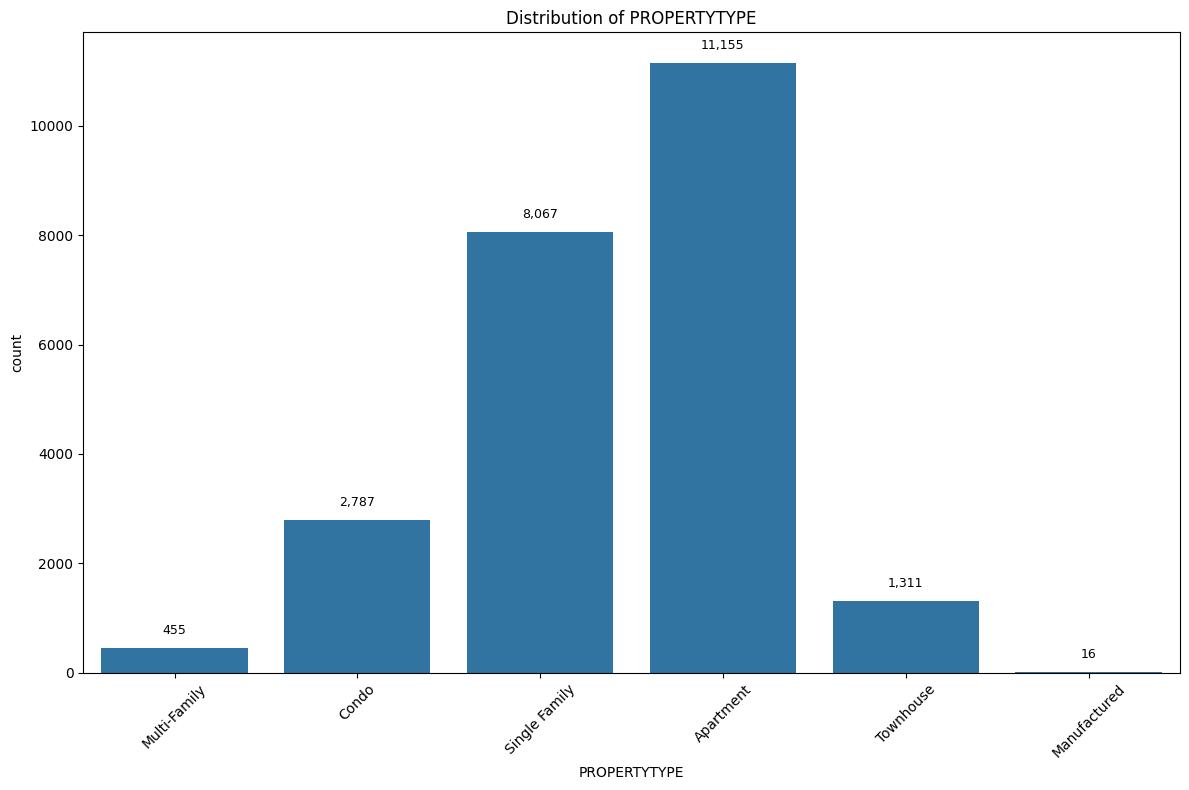

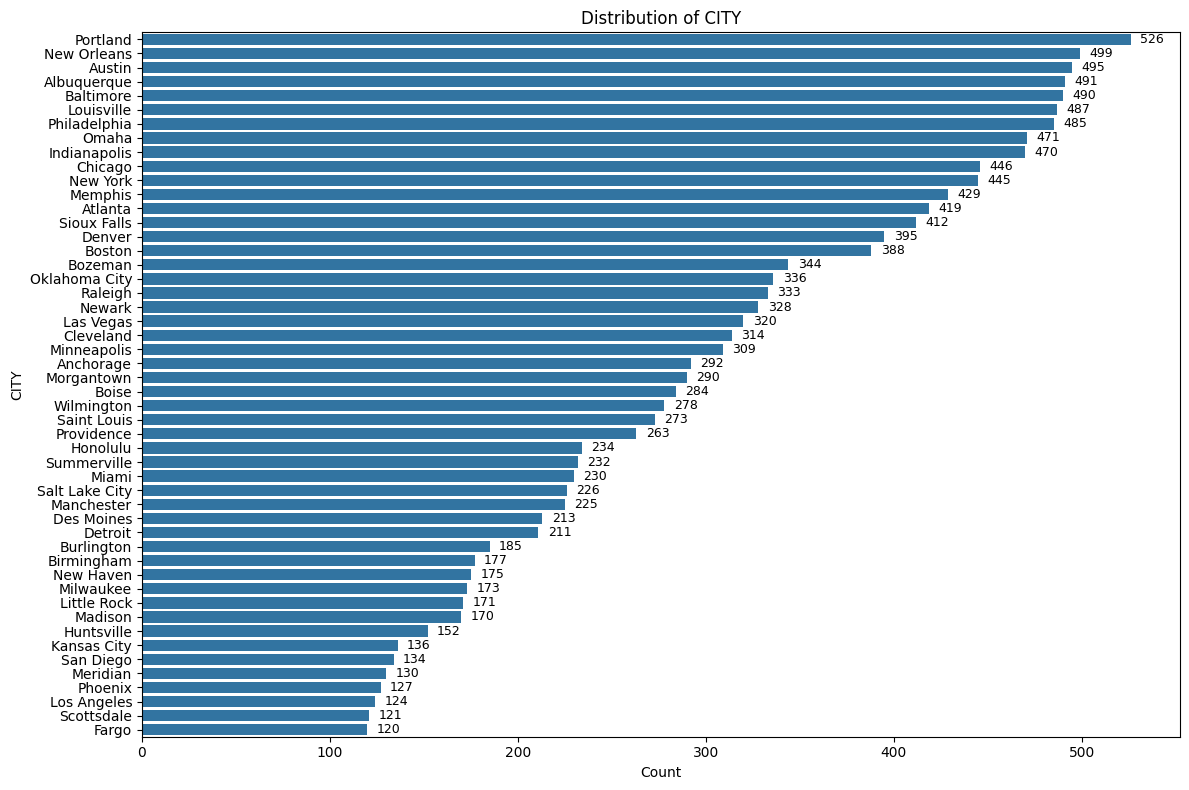

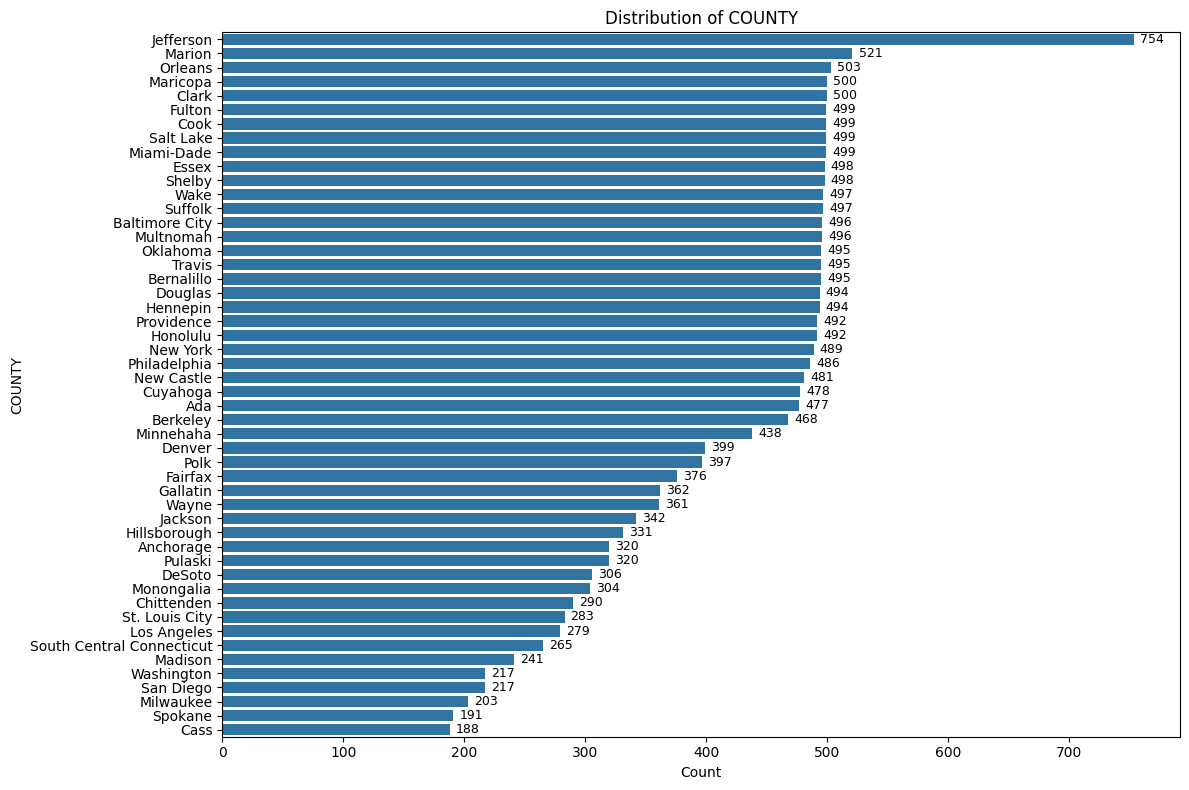

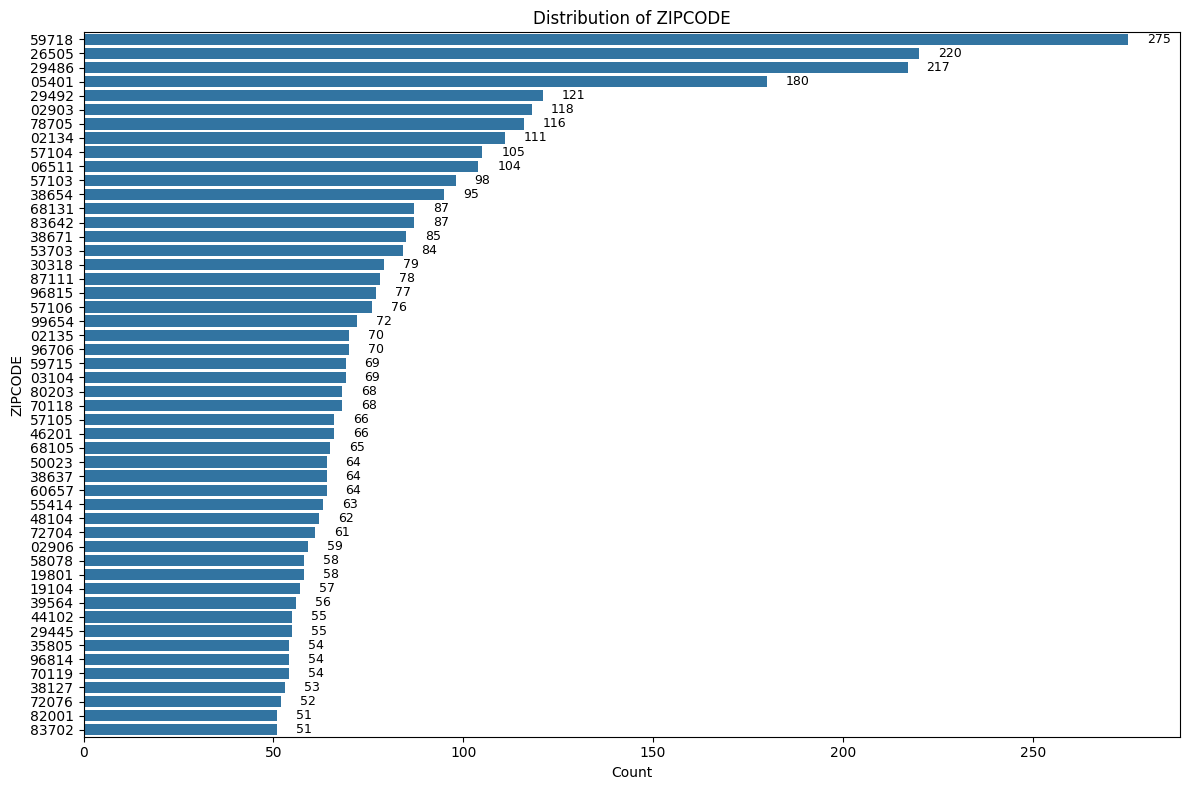

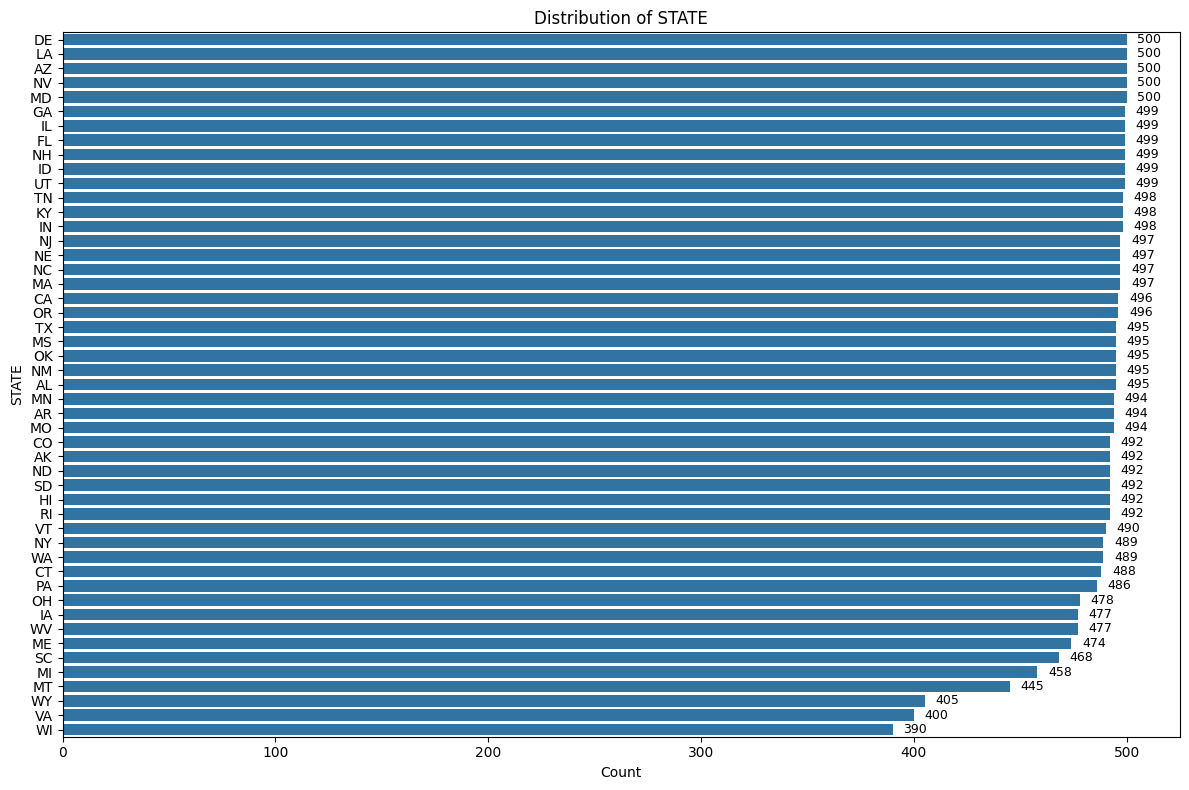

In [31]:
# Visualize categorical distributions (horizontal for CITY, COUNTY and STATE)
for col in ["LISTINGTYPE", "PROPERTYTYPE", "CITY", "COUNTY", "ZIPCODE", "STATE"]:
    plt.figure(figsize=(12, 8))

    if col in ["CITY",  "COUNTY", "ZIPCODE", "STATE"]:
        top = data[col].value_counts().head(50).index
        df_plot = data[data[col].isin(top)]
        ax = sns.countplot(data=df_plot, y=col, order=top)  # horizontal
        plt.xlabel("Count")
        plt.ylabel(col)

        # Add count labels at end of bars (horizontal)
        for p in ax.patches:
            width = p.get_width()
            ax.text(
                width + 5,                          # a bit to the right of the bar
                p.get_y() + p.get_height() / 2,     # centered vertically
                f"{int(width):,}",
                va="center",
                fontsize=9
            )

    else:
        ax = sns.countplot(data=data, x=col)
        plt.xticks(rotation=45)

        # Add count labels above bars (vertical)
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,
                height + 200,
                f"{int(height):,}",
                ha="center",
                va="bottom",
                fontsize=9
            )

    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


**ANALYSIS**

a. LISTINGTYPE: Observation: The plot confirms extreme imbalance (Standard: 23,673 vs New Construction: 118). This variable remains highly imbalanced and it is unlikely to add meaningful predictive power due to lack of variation. It can be dropped or used as a secondary filter if the goal is to isolate newly constructed properties.

b. PROPERTYTYPE: Dominant types are Apartment (11,155) and Single Family (8,067), Mid-tier includes Condo (2,787) and Townhouse (1,311) while the rare type are the Multi-Family (455), Manufactured (16). This is a highly informative feature for segmentation and modeling. Apartments and Single Family homes should be modeled separately if pricing is sensitive to type. Very rare categories (like Manufactured) can be excluded in modeling to avoid skewed metrics or group them under an “Other” class.

c. CITY: Cities like Portland, New Orleans, and Austin each have approximately 500 listings. Distribution is broad but relatively even at the top 50 cities. This is a valuable geographic variable and there is sufficient data for city-level segmentation and insights. Avoid averaging across cities—model or analyze each metro separately to reflect local market dynamics.

d. COUNTY: Jefferson County with 754 listings standout. Most other counties clustered around 495–500. It is similar to CITY but the uniformity hints at row limits per region (possibly sampling bias or API quota). Treat county-level trends with caution, especially when many values hit round numbers like 500.

e. STATE: Nearly every state has 500 listings which is highly uniform. There is strong evidence of capped or quota-limited sampling (possibly 500 listings/state). Do not use STATE as a primary segmentation or modeling feature as it does not reflect real supply. Instead, treat it as a meta attribute or fallback category for broad rollups.

f. ZIPCODE: A few ZIP codes dominate listing volume (e.g., 59718 = 275, 26505 = 220). The distribution shows a long-tail shape, with most ZIP codes having fewer than 100 listings. There is a steep drop-off beyond the top ZIPs, and many ZIPs are underrepresented. High-volume ZIPs are suitable for individual trend modeling and deeper analysis. ZIPs with fewer listings are too sparse for standalone modeling and may introduce noise or instability. The uneven distribution indicates the dataset likely reflects platform sampling or market-specific activity and not comprehensive ZIP-level market coverage.

g. Real-time insights (Operational Recommendation):Agg regating at the state level will hide trends. Focus on ZIP code or city-level features like: Price trends, Days on Market, Listing frequency / volume and pair with external economic/demographic data by ZIP or metro for deeper insights.

**Final Recommendations:** Drop or de-emphasize LISTINGTYPE (very low variability). Use PROPERTYTYPE for modeling segmentation (strong signal and good variability). Avoid over-reliance on STATE and COUNTY for insights (likely sampling caps). Use CITY for geographic rollups, filtering, or even dedicated dashboards. Model pricing and trends at the CITY or ZIP + PROPERTYTYPE grain for best precision. Add external datasets (e.g., rental indices, income, demand by ZIP) to go beyond the limitations of listing data alone.




**NUMERICAL COLUMNS COUNT**

In [32]:
# List all numeric columns
numeric_cols = data.select_dtypes(include=["number"]).columns.tolist()

print(f"Number columns ({len(numeric_cols)}):")
print(numeric_cols)

Number columns (9):
['PRICE', 'BEDROOMS', 'LATITUDE', 'BATHROOMS', 'LONGITUDE', 'STATEFIPS', 'COUNTYFIPS', 'DAYSONMARKET', 'SQUAREFOOTAGE']


Numeric columns: ['PRICE', 'BEDROOMS', 'LATITUDE', 'BATHROOMS', 'LONGITUDE', 'STATEFIPS', 'COUNTYFIPS', 'DAYSONMARKET', 'SQUAREFOOTAGE']


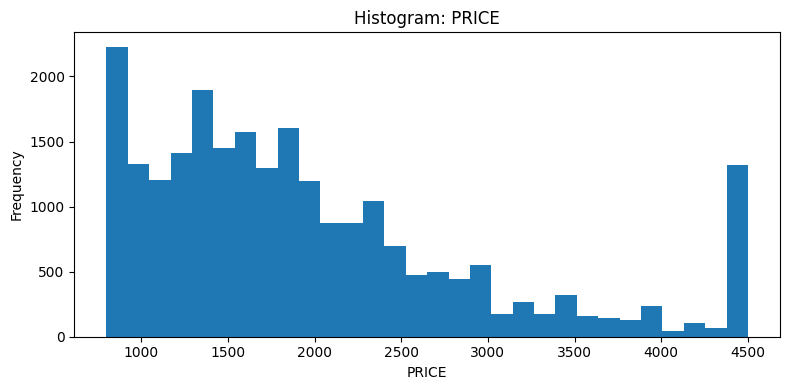

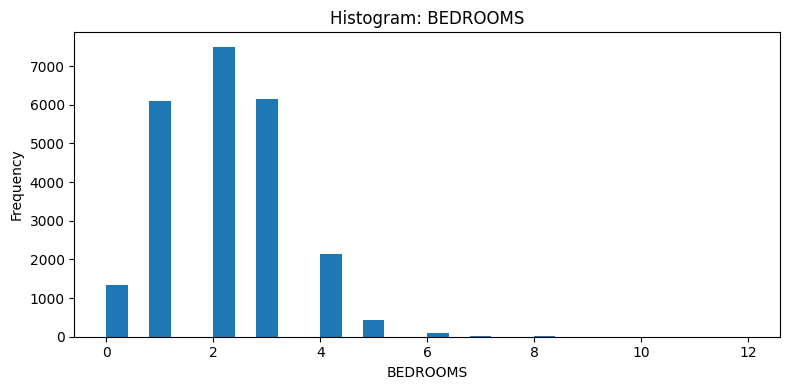

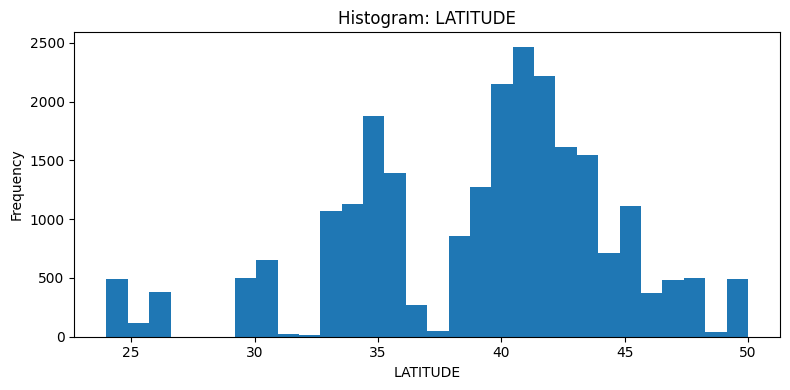

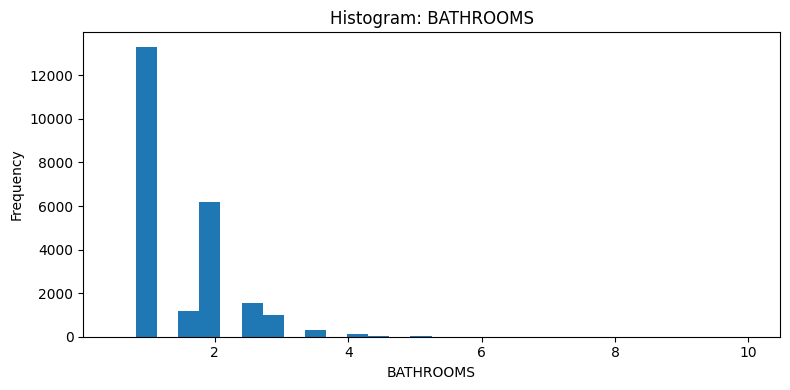

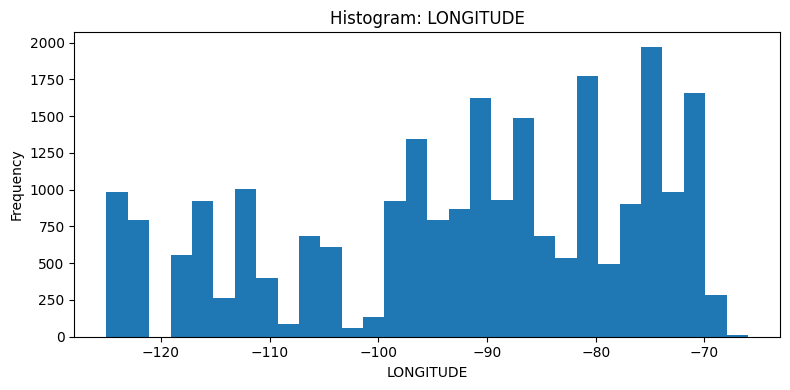

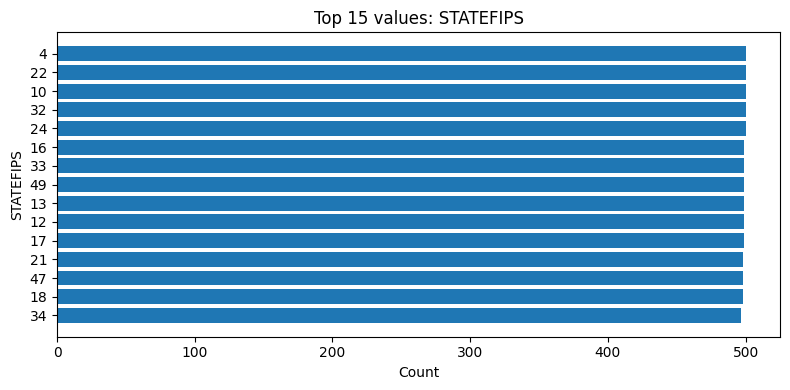

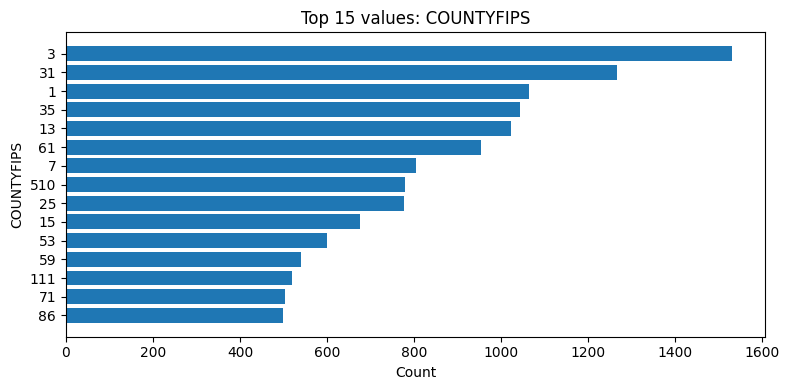

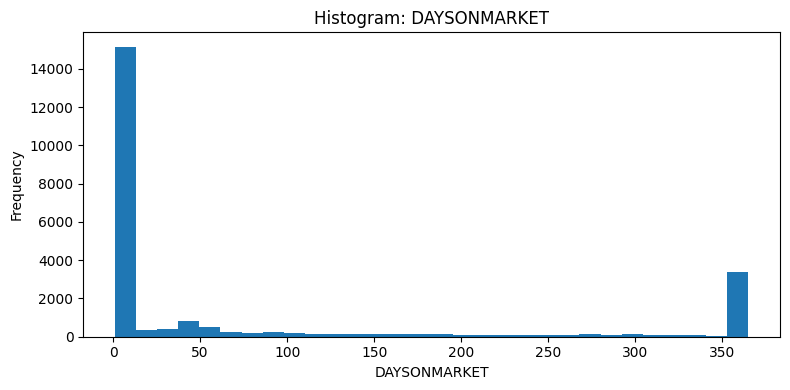

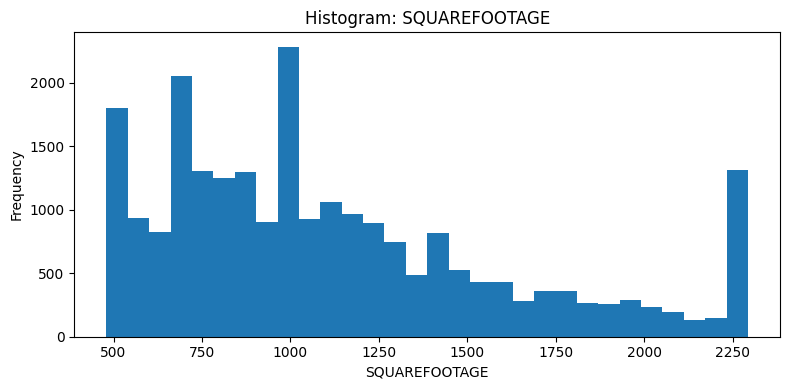

In [35]:
# 1) Get numeric columns 
numeric_cols = data.select_dtypes(include=["number"]).columns.tolist()
print("Numeric columns:", numeric_cols)

# (optional) columns that are IDs/codes -> usually NOT meaningful to histogram
code_like = {"STATEFIPS", "COUNTYFIPS"}

# 2) Univariate plots: histogram (only) for each numeric column
for col in numeric_cols:
    s = pd.to_numeric(data[col], errors="coerce").dropna()

    # Skip empty columns
    if s.empty:
        continue

    plt.figure(figsize=(8, 4))

    # Histogram (or bar plot for code-like)
    if col in code_like:
        top = s.astype(int).astype(str).value_counts().head(15).sort_values()
        plt.barh(top.index, top.values)
        plt.title(f"Top 15 values: {col}")
        plt.xlabel("Count")
        plt.ylabel(col)
    else:
        plt.hist(s, bins=30)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


**ANALYSIS**

a. PRICE

Visuals: Right-skewed histogram with a spike at the upper end.

Insight: Price distribution shows a strong right-skew, reflecting a mix of affordable and premium listings. There’s a notable spike near the price cap (possibly a data max). Consider log transformation to reduce skew before modeling. Flag or cap luxury outliers if the model is sensitive to them.

b. BEDROOMS

Visuals: Peak at 2–3 bedrooms and few listings with 6+.

Insight: Listings are highly concentrated between 1–3 bedrooms, with very few large-bedroom properties (e.g., 6–12 bedrooms), which reflect niche markets. Retain all values but consider binning at the upper end to reduce outlier impact in modeling.

c. LATITUDE

Visuals: Multi-modal histogram with peaks around 30–45° latitude.

Insight: The distribution confirms coverage across multiple U.S. regions (e.g., southern and northern states). Geographic diversity is present. Use for geo-segmentation (e.g., clustering or regional modeling). Avoid interpreting latitude as a continuous feature in isolation.

d. BATHROOMS

Visuals: Dominated by 1–2 baths; long right tail.

Insight: Most listings have 1 or 2 bathrooms, with few luxury units above 3. Retain higher-bathroom listings for luxury analysis. Consider log transformation in price modeling.

e. LONGITUDE

Visuals: Spread across -125 to -70, confirming wide U.S. coverage.

Insight: The spread suggests a good geographic mix across east/west U.S. Useful for spatial analysis or clustering. Like latitude, avoid direct interpretation without geographic context.

f. STATEFIPS

Visuals: Flat distribution; top states capped at ~500 listings.

Insight: Strong evidence of sample caps per state—suggesting artificial uniformity rather than true volume. Use STATEFIPS only for labeling, filtering, or mapping. Avoid statistical comparisons across states.

g. DAYSONMARKET

Visuals: Large spike at 0–10 days; long tail up to 365.

Insight: Indicates many fast-moving listings and some stale ones. Tail likely reflects old or relisted properties.Consider log-transforming or binning into time buckets (e.g., 0–7, 8–30, 31–90, 90+). 

h. SQUAREFOOTAGE

Visuals: Right-skewed histogram; notable spike at upper end (~2250 sqft).

Insight: Most listings are between 500–1500 sqft, with luxury units at higher sizes. Use as-is but log-transform or normalize for modeling. Cap extreme values to reduce undue influence.

i. COUNTYFIPS

Visuals: Top counties vary significantly (e.g., one with over 1500 listings).

Insight: Some counties dominate the dataset, likely due to urban area concentration. Others are underrepresented. Use for regional filtering or modeling, but be aware of skew. Consider combining with population data for per-capita normalization.

**EDA 2 -BIVARIATE EXPLORATORY DATA ANALYSIS**

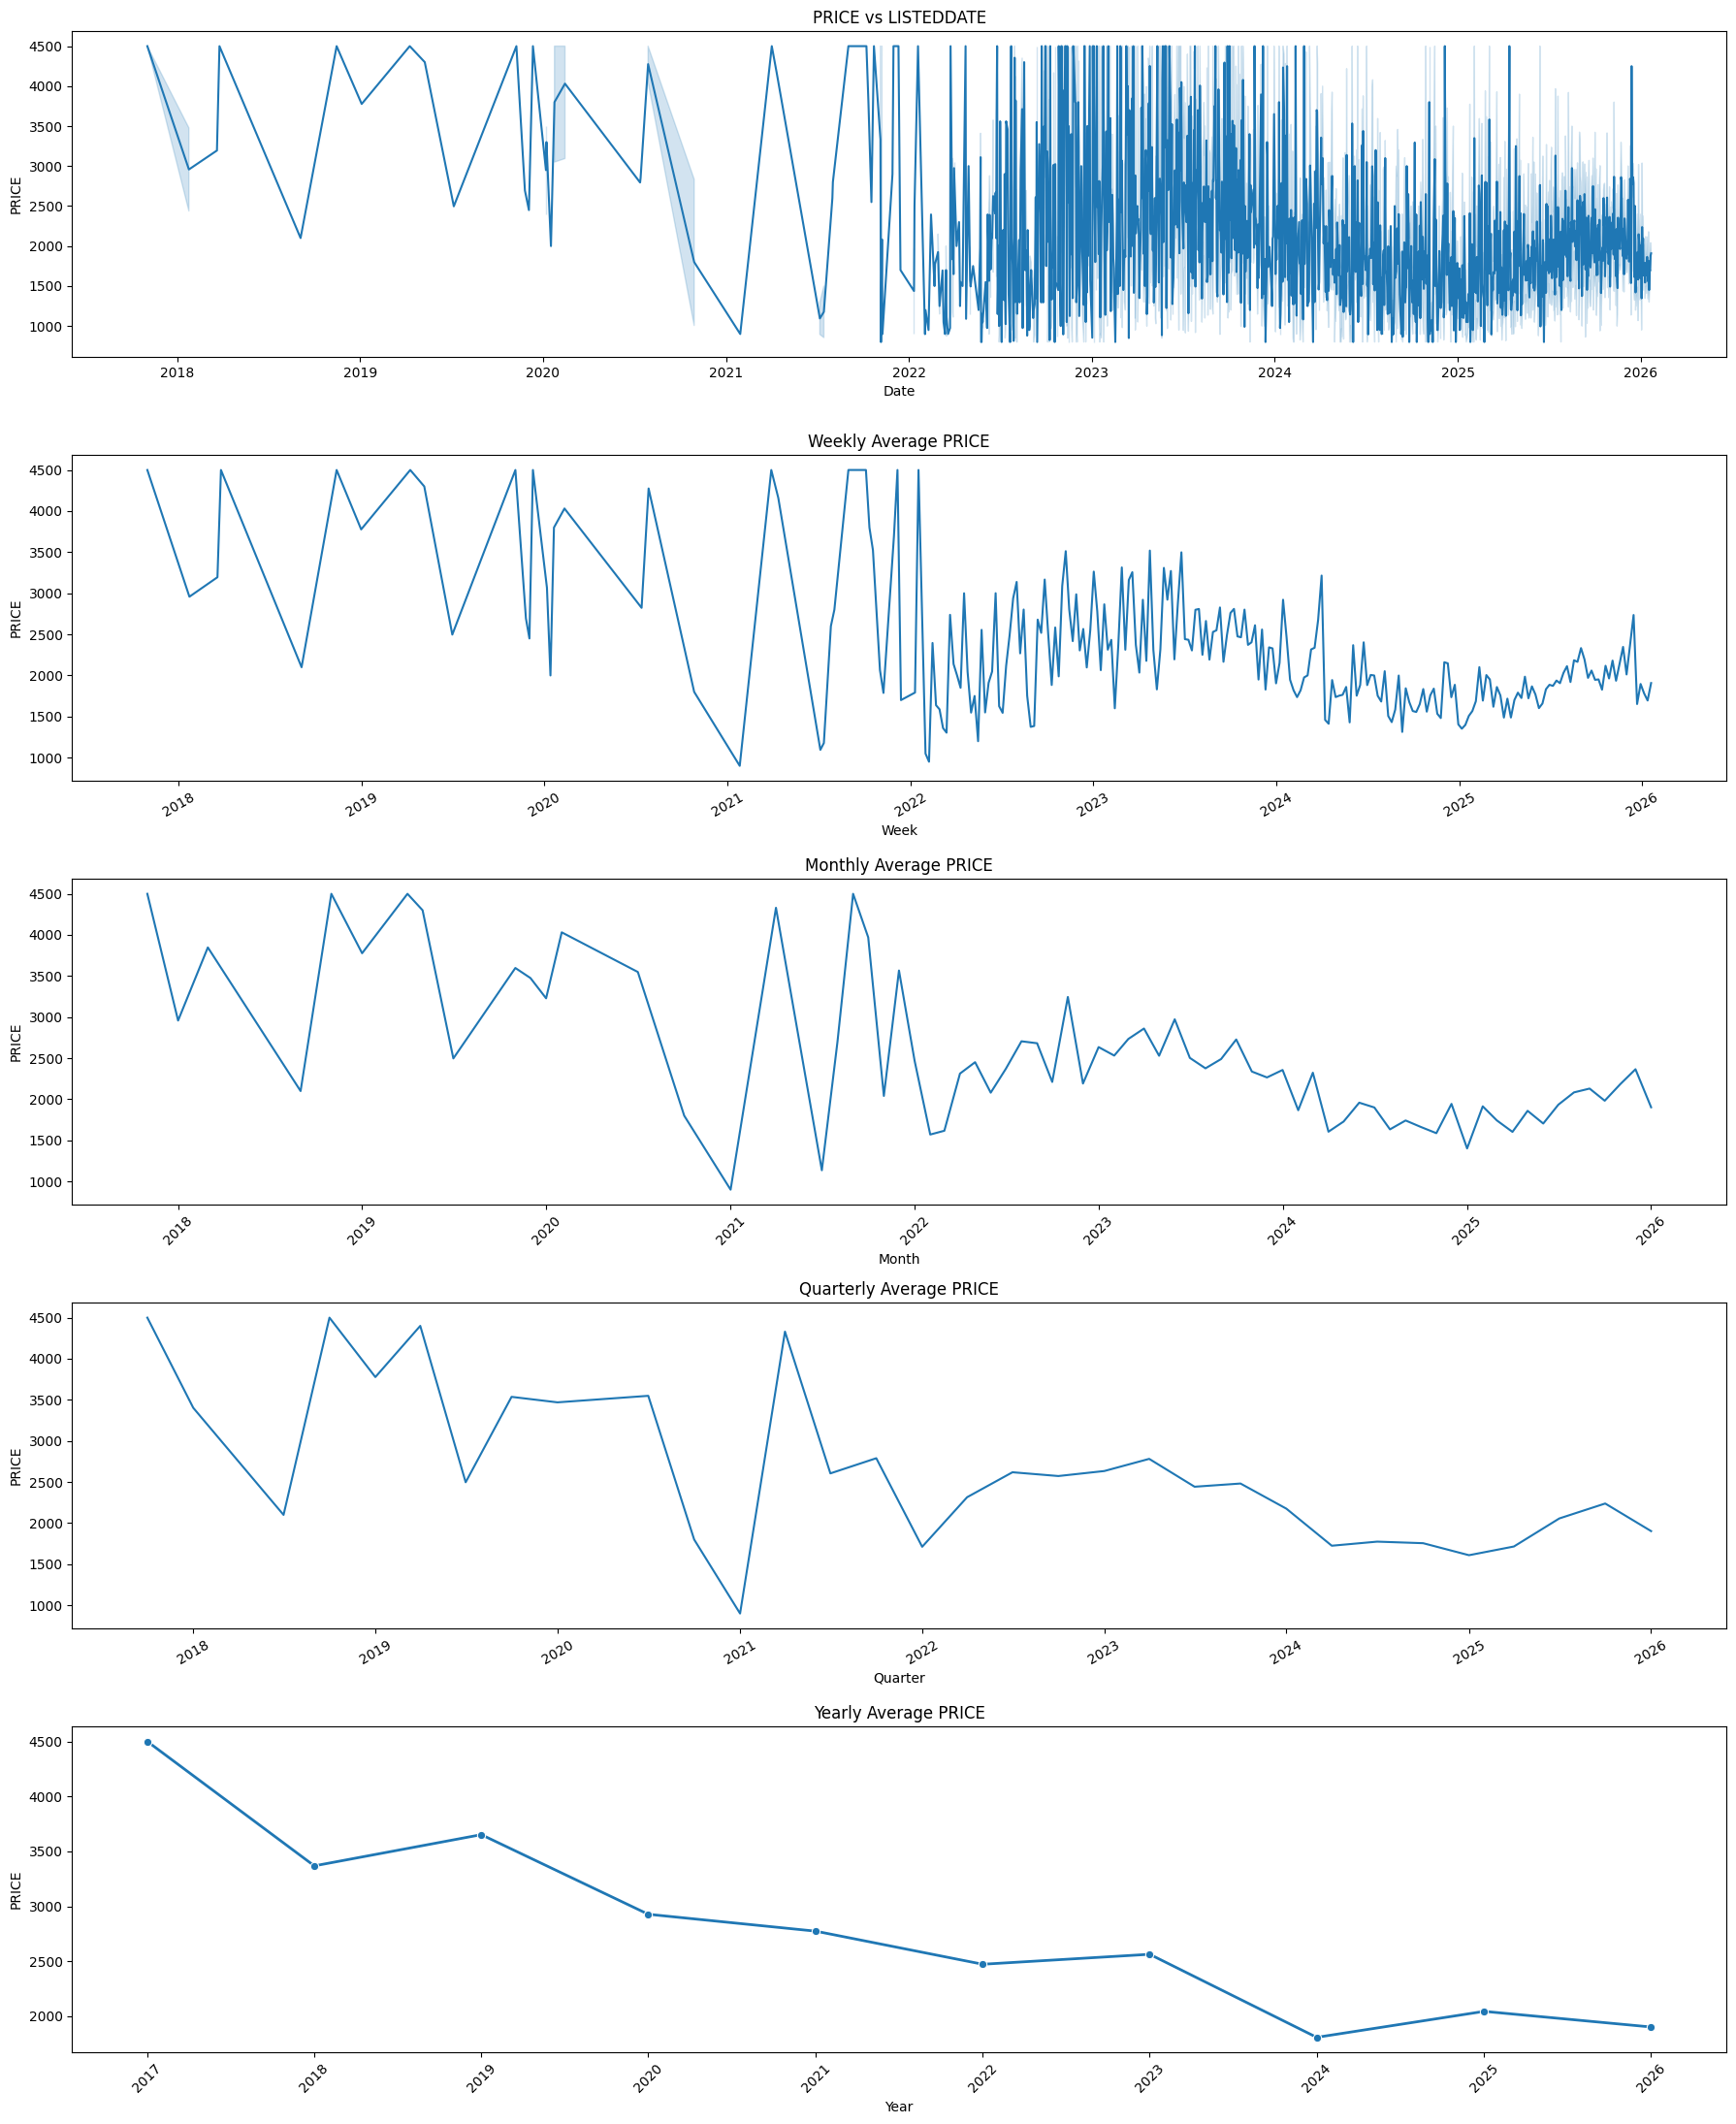

In [14]:
# LISTEDDATE vs PRICE analysis

# Ensure LISTEDDATE is datetime
data['LISTEDDATE'] = pd.to_datetime(data['LISTEDDATE'])

# Drop missing PRICE or LISTEDDATE
df = data.dropna(subset=["LISTEDDATE", "PRICE"]).copy()
df = df.sort_values("LISTEDDATE")

# Create time-based columns
df['LISTED_WEEK'] = df['LISTEDDATE'].dt.to_period('W').dt.start_time
df['LISTED_MONTH'] = df['LISTEDDATE'].dt.to_period('M').dt.start_time
df['LISTED_QUARTER'] = df['LISTEDDATE'].dt.to_period('Q').dt.start_time
df['LISTED_YEAR'] = df['LISTEDDATE'].dt.to_period('Y').dt.start_time  # Keep as datetime-like

# Aggregations
weekly_avg = df.groupby('LISTED_WEEK')['PRICE'].mean().reset_index()
monthly_avg = df.groupby('LISTED_MONTH')['PRICE'].mean().reset_index()
quarterly_avg = df.groupby('LISTED_QUARTER')['PRICE'].mean().reset_index()
yearly_avg = df.groupby('LISTED_YEAR')['PRICE'].mean().reset_index()

# Set up 5-row plot grid (1 column per row)
fig, axes = plt.subplots(5, 1, figsize=(18, 22))  # 5 rows, 1 column

# 1. Raw PRICE over time
sns.lineplot(data=df, x='LISTEDDATE', y='PRICE', ax=axes[0])
axes[0].set_title("PRICE vs LISTEDDATE")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("PRICE")

# 2. Weekly trend
sns.lineplot(data=weekly_avg, x='LISTED_WEEK', y='PRICE', ax=axes[1])
axes[1].set_title("Weekly Average PRICE")
axes[1].set_xlabel("Week")
axes[1].tick_params(axis='x', rotation=30)

# 3. Monthly trend
sns.lineplot(data=monthly_avg, x='LISTED_MONTH', y='PRICE', ax=axes[2])
axes[2].set_title("Monthly Average PRICE")
axes[2].set_xlabel("Month")
axes[2].tick_params(axis='x', rotation=45)

# 4. Quarterly trend
sns.lineplot(data=quarterly_avg, x='LISTED_QUARTER', y='PRICE', ax=axes[3])
axes[3].set_title("Quarterly Average PRICE")
axes[3].set_xlabel("Quarter")
axes[3].tick_params(axis='x', rotation=30)

# 5. Yearly trend
sns.lineplot(data=yearly_avg, x='LISTED_YEAR', y='PRICE', ax=axes[4], marker='o', linewidth=2)
axes[4].set_title("Yearly Average PRICE")
axes[4].set_xlabel("Year")
axes[4].set_ylabel("PRICE")
axes[4].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


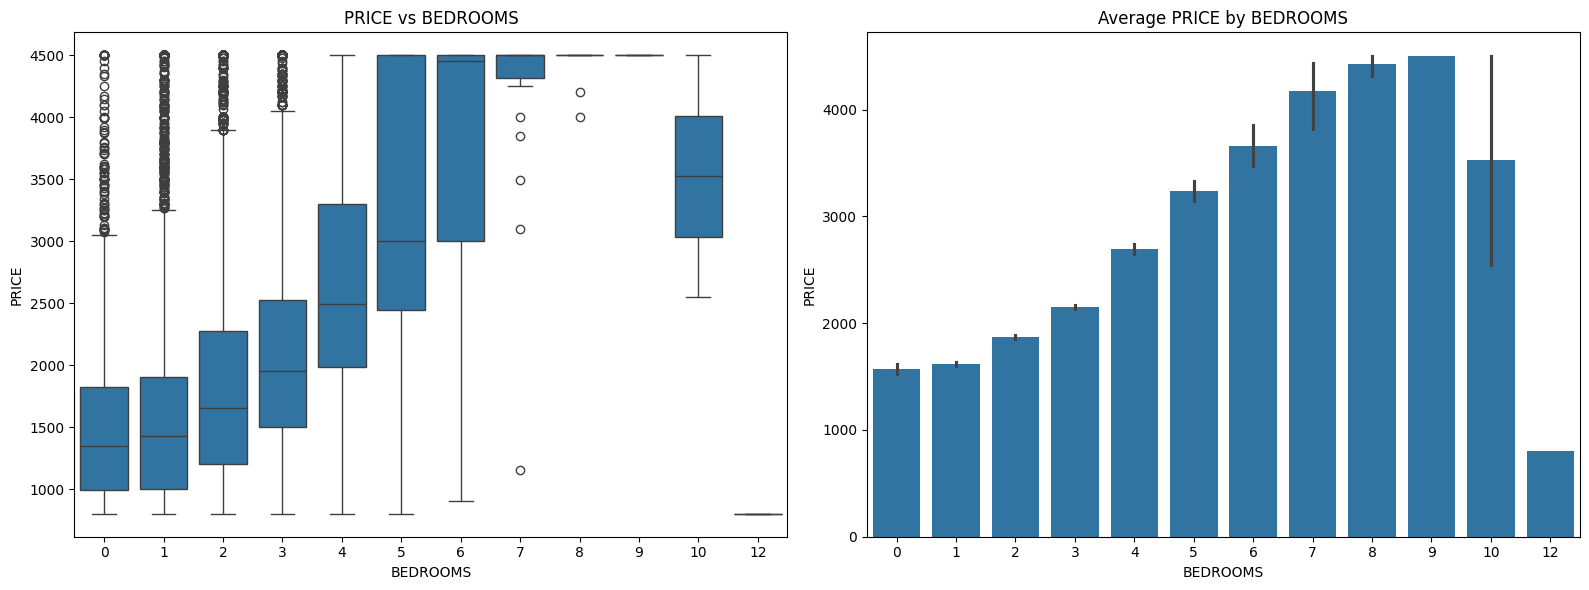

In [15]:
# BEDROOMS vs PRICE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='BEDROOMS', y='PRICE', data=df, ax=axes[0])
axes[0].set_title('PRICE vs BEDROOMS')

sns.barplot(x='BEDROOMS', y='PRICE', data=df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Average PRICE by BEDROOMS')

plt.tight_layout()
plt.show()

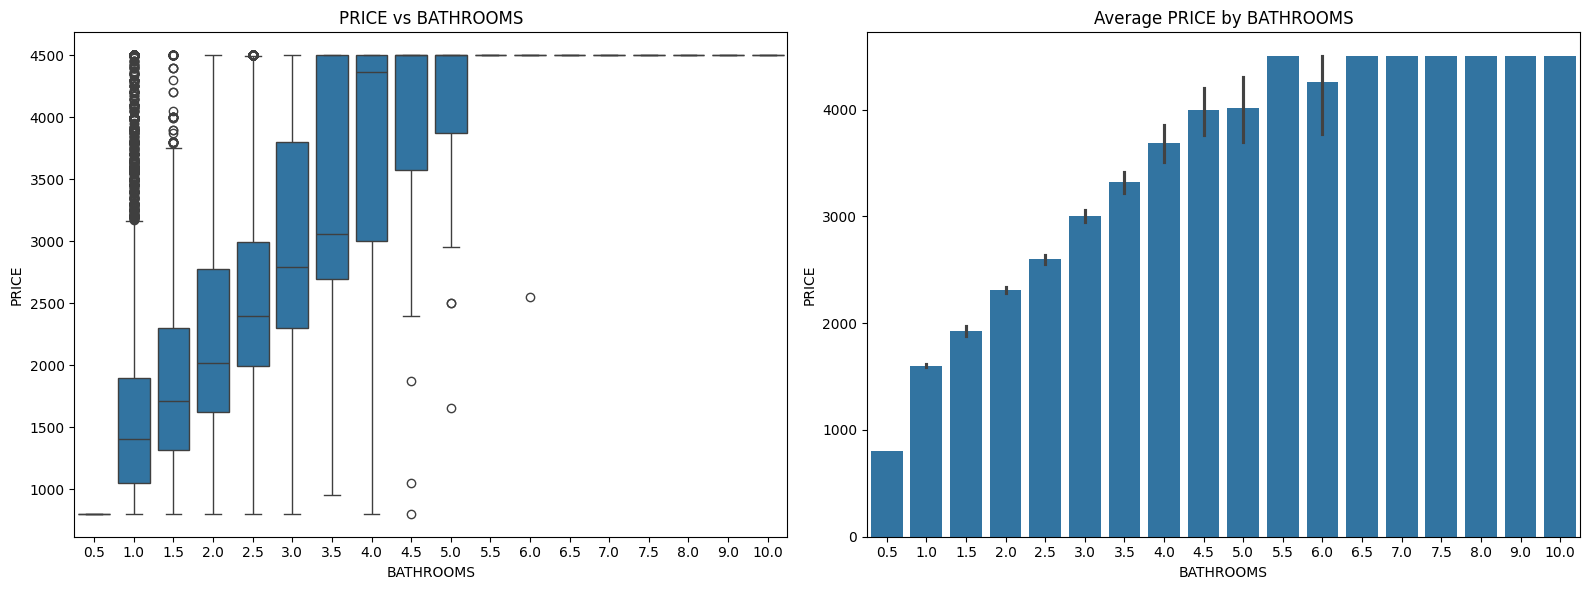

In [16]:
# BATHROOMS vs PRICE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='BATHROOMS', y='PRICE', data=df, ax=axes[0])
axes[0].set_title('PRICE vs BATHROOMS')

sns.barplot(x='BATHROOMS', y='PRICE', data=df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Average PRICE by BATHROOMS')

plt.tight_layout()
plt.show()

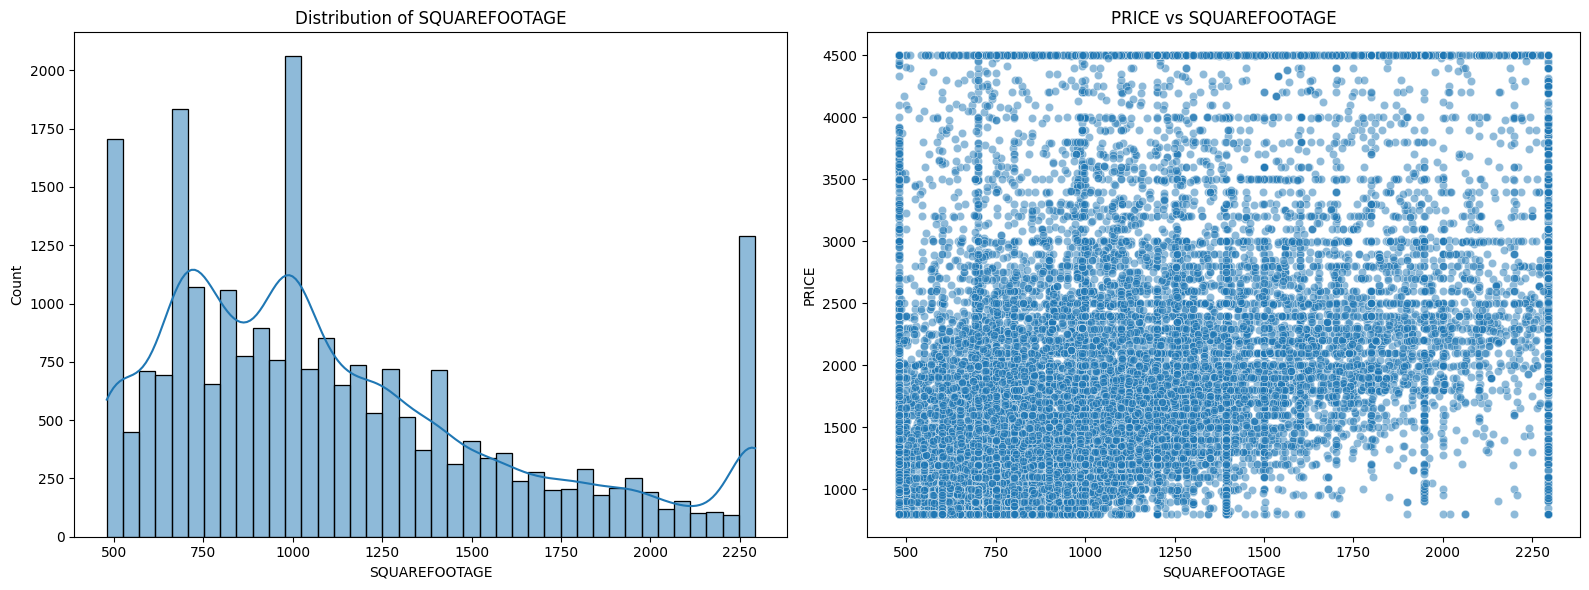

In [17]:
# SQUAREFOOTAGE vs PRICE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['SQUAREFOOTAGE'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Distribution of SQUAREFOOTAGE')

sns.scatterplot(x='SQUAREFOOTAGE', y='PRICE', data=df, alpha=0.5, ax=axes[1])
axes[1].set_title('PRICE vs SQUAREFOOTAGE')

plt.tight_layout()
plt.show()

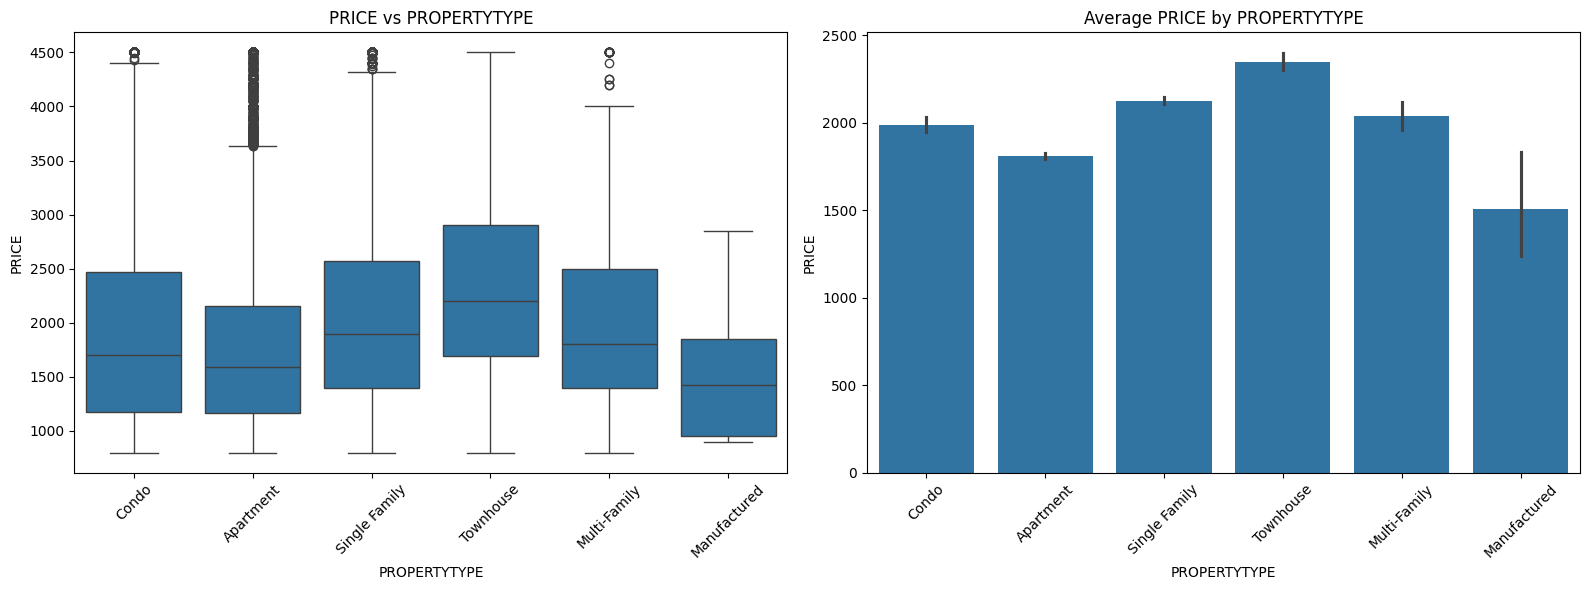

In [18]:
# PROPERTYTYPE vs PRICE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='PROPERTYTYPE', y='PRICE', data=df, ax=axes[0])
axes[0].set_title('PRICE vs PROPERTYTYPE')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='PROPERTYTYPE', y='PRICE', data=df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Average PRICE by PROPERTYTYPE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


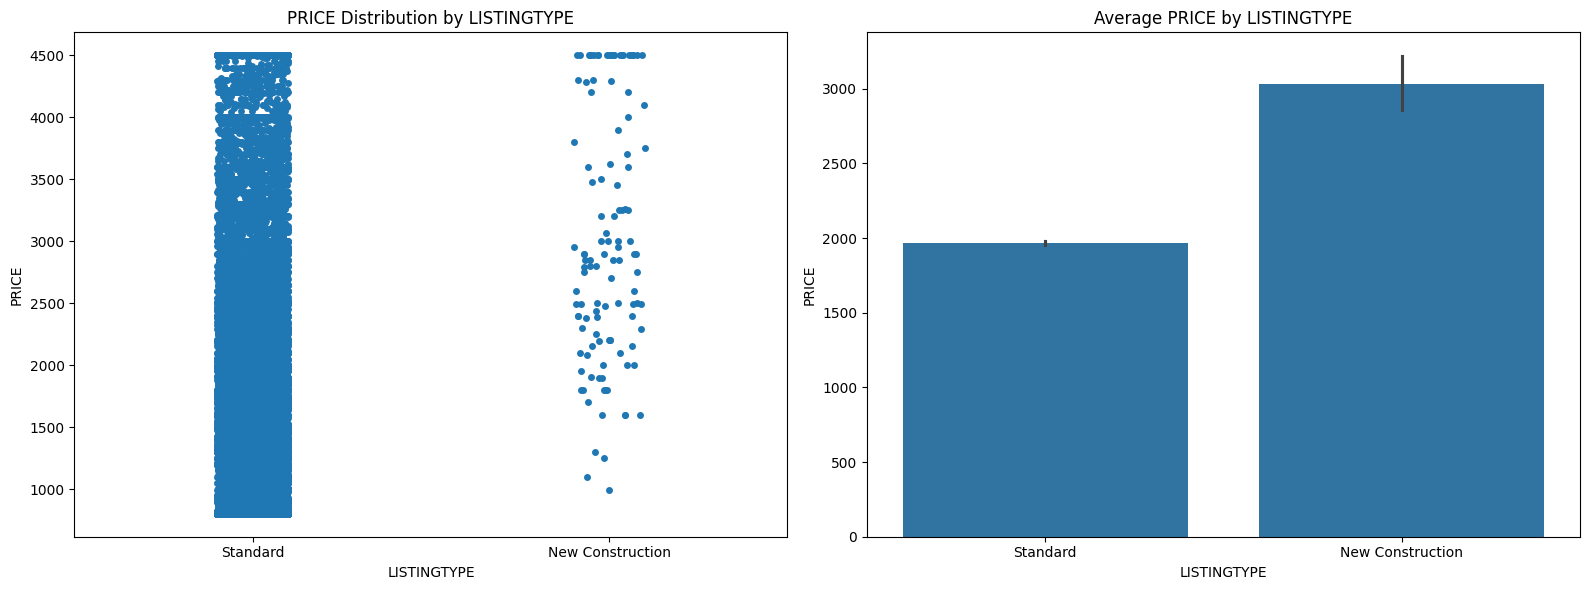

In [19]:
# LISTINGTYPE vs PRICE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.stripplot(x='LISTINGTYPE', y='PRICE', data=df, jitter=True, ax=axes[0])
axes[0].set_title('PRICE Distribution by LISTINGTYPE')

sns.barplot(x='LISTINGTYPE', y='PRICE', data=df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Average PRICE by LISTINGTYPE')

plt.tight_layout()
plt.show()

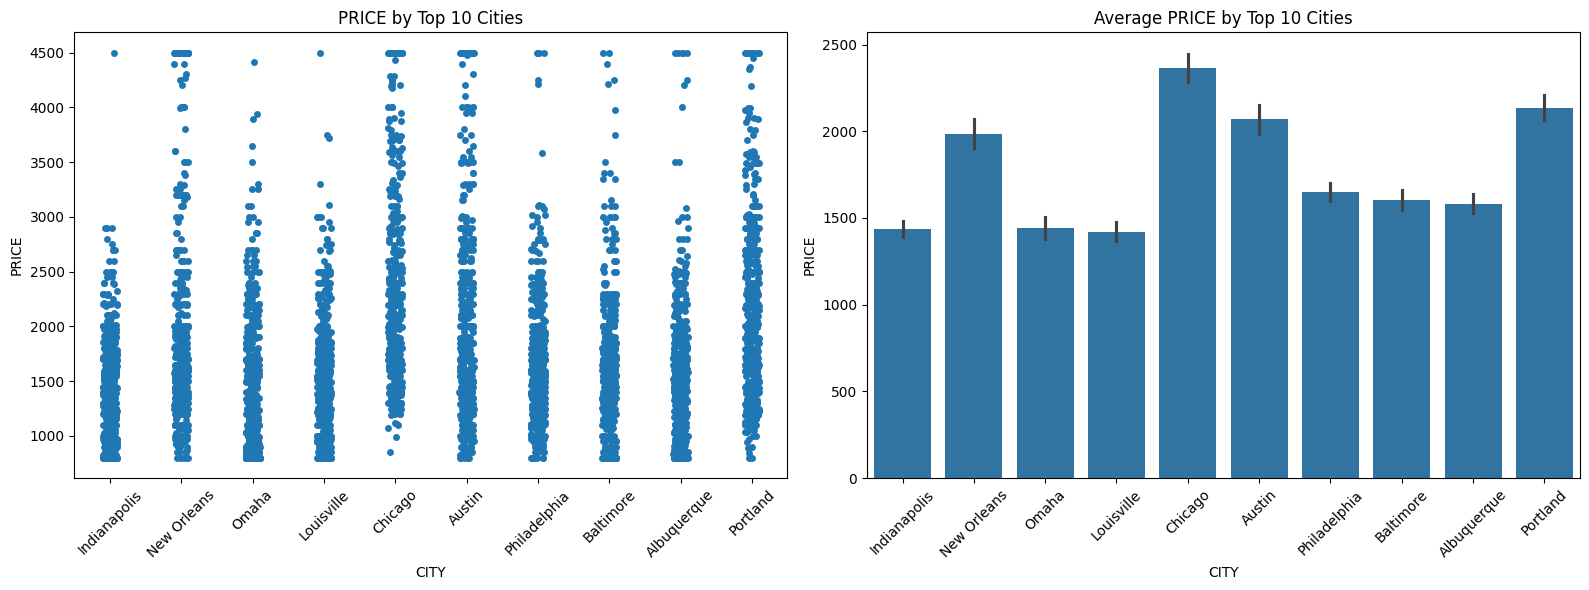

In [20]:
# CITY (Top 10) vs PRICE

top_cities = df['CITY'].value_counts().nlargest(10).index

top_city_df = df[df['CITY'].isin(top_cities)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.stripplot(x='CITY', y='PRICE', data=top_city_df, jitter=True, ax=axes[0])
axes[0].set_title('PRICE by Top 10 Cities')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='CITY', y='PRICE', data=top_city_df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Average PRICE by Top 10 Cities')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**ANALYSIS**

1. PRICE Trends over Time (LISTEDDATE)

a. Daily PRICE: High-frequency volatility in daily prices, especially dense after 2022. This indicates a sharp increase in listings volume post-2022, which could possibly due to better data acquisition or market shifts. The price trend becomes more stable but generally lower over time.

b. Weekly Average PRICE: Weekly granularity confirms short-term price volatility. Prices show gradual decline after 2021. Short-term stability improves post-2023.

c. Monthly Average PRICE: Seasonal spikes taper off post-2020. There is clear downward trajectory from 2021. Seasonality weakens as prices flatten.

d. Quarterly Average PRICE: Smooths short-term noise. Sharp dip post-2020 with slight uptrends failing to sustain. This supports macro-level market softening.

e. Yearly Average PRICE: Peak observed between 2017–2019, followed by a consistent yearly decline. Long-term market cooling is evident.

2. PRICE vs BEDROOMS: The boxplot shows clear positive relationship with median prices rise with more bedrooms. Outliers more common for 0–3 bedroom listings (especially for 0, likely studios or anomalies). The barplot shows average prices increase steadily until 7–9 bedrooms. After that, prices either plateau or dip slightly likely due to low sample sizes or luxury saturation. Model bedrooms as an ordinal feature (or bins above 6+ together). Zero-bedroom cases might need special handling (e.g. studio flats or data entry errors).

3. PRICE vs BATHROOMS: The plots (boxplot & barplot) show strong positive correlation. Median price increases with bathrooms, plateauing around 5+. There is slight decrease in price variability at the upper end which suggests saturation in luxury segment. It is a useful predictor. Consider capping at 5+ bathrooms in predictive models for stability.

4. SQUAREFOOTAGE vs PRICE: Histogram shows most homes fall between 500–1500 sqft, confirming right-skew while the scatterplot shows a positive but noisy correlation with price. Dense horizontal bands at the price ceiling (~4500) suggest price cap enforcement or rounding. Consider log transformation, handle price ceiling artifacts and feature interaction with bedrooms/bathrooms

5. PRICE vs PROPERTYTYPE: The boxplot shows Townhouse > Single Family > Condo > Apartment > Manufactured. Manufactured homes have both lowest prices and highest variability. The barplot shows Townhouses consistently command highest average prices, followed by Single Family. Apartments and Manufactured homes fall behind. Segment modeling by PROPERTYTYPE is strongly justified. Manufactured homes could either be modeled separately or flagged as a low-price class

6. PRICE vs LISTINGTYPE: The scatter and barplot show that New Construction listings have higher average prices than Standard listings but its volume is low and the error bars are wide. LISTINGTYPE has limited predictive value due to imbalance but could be used as a binary feature in certain segmentation.

7. PRICE by Top 10 Cities: The scatterplot shows clear variation in price spread and central tendency across cities. 
Chicago and Portland show high price averages and wide ranges. Indianapolis, Louisville, Omaha show tighter, lower distributions. The barplot shows that Chicago is higher than Portland and New Orleans in terms of average price.

Recommendation: City-level modeling is critical. There  may be consideration for adding external variables (e.g. income, rent index) for each city to improve generalizability.

**Market Insights:** Prices have steadily declined since 2019, across all time granularities. Property characteristics (bedrooms, bathrooms, sqft) are strong predictors of price. Geographic factors (CITY, PROPERTYTYPE) reveal key price segmentation. New constructions, though rare, carry significant pricing premiums.

**Recommendations**

Investors - Focus on cities with stable or rebounding prices (e.g., Chicago, Portland). Look for undervalued townhouses or large units.
Sellers - List high-end/new-construction units sooner to avoid value erosion in a cooling market.
Buyers - Favour cities with consistent low pricing (e.g., Indianapolis, Louisville). It's a buyer’s market for mid-sized homes.
Developers - Prioritize 3–5 bedroom, 2–4 bathroom units. Avoid over-investment in extreme luxury sizing.
Policy Makers - Long-term price decline may signal affordability or demand issues—may warrant housing assistance programs or market stimulation.

**EDA 3 - MULTIVARIATE EXPLORATORY DATA ANALYSIS**

C:\Users\USER\AppData\Local\Temp\ipykernel_27968\2515110080.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="M"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_27968\2515110080.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Q"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_27968\2515110080.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Y"), "PROPERTYTYPE"])["PRICE"].median().reset_index()


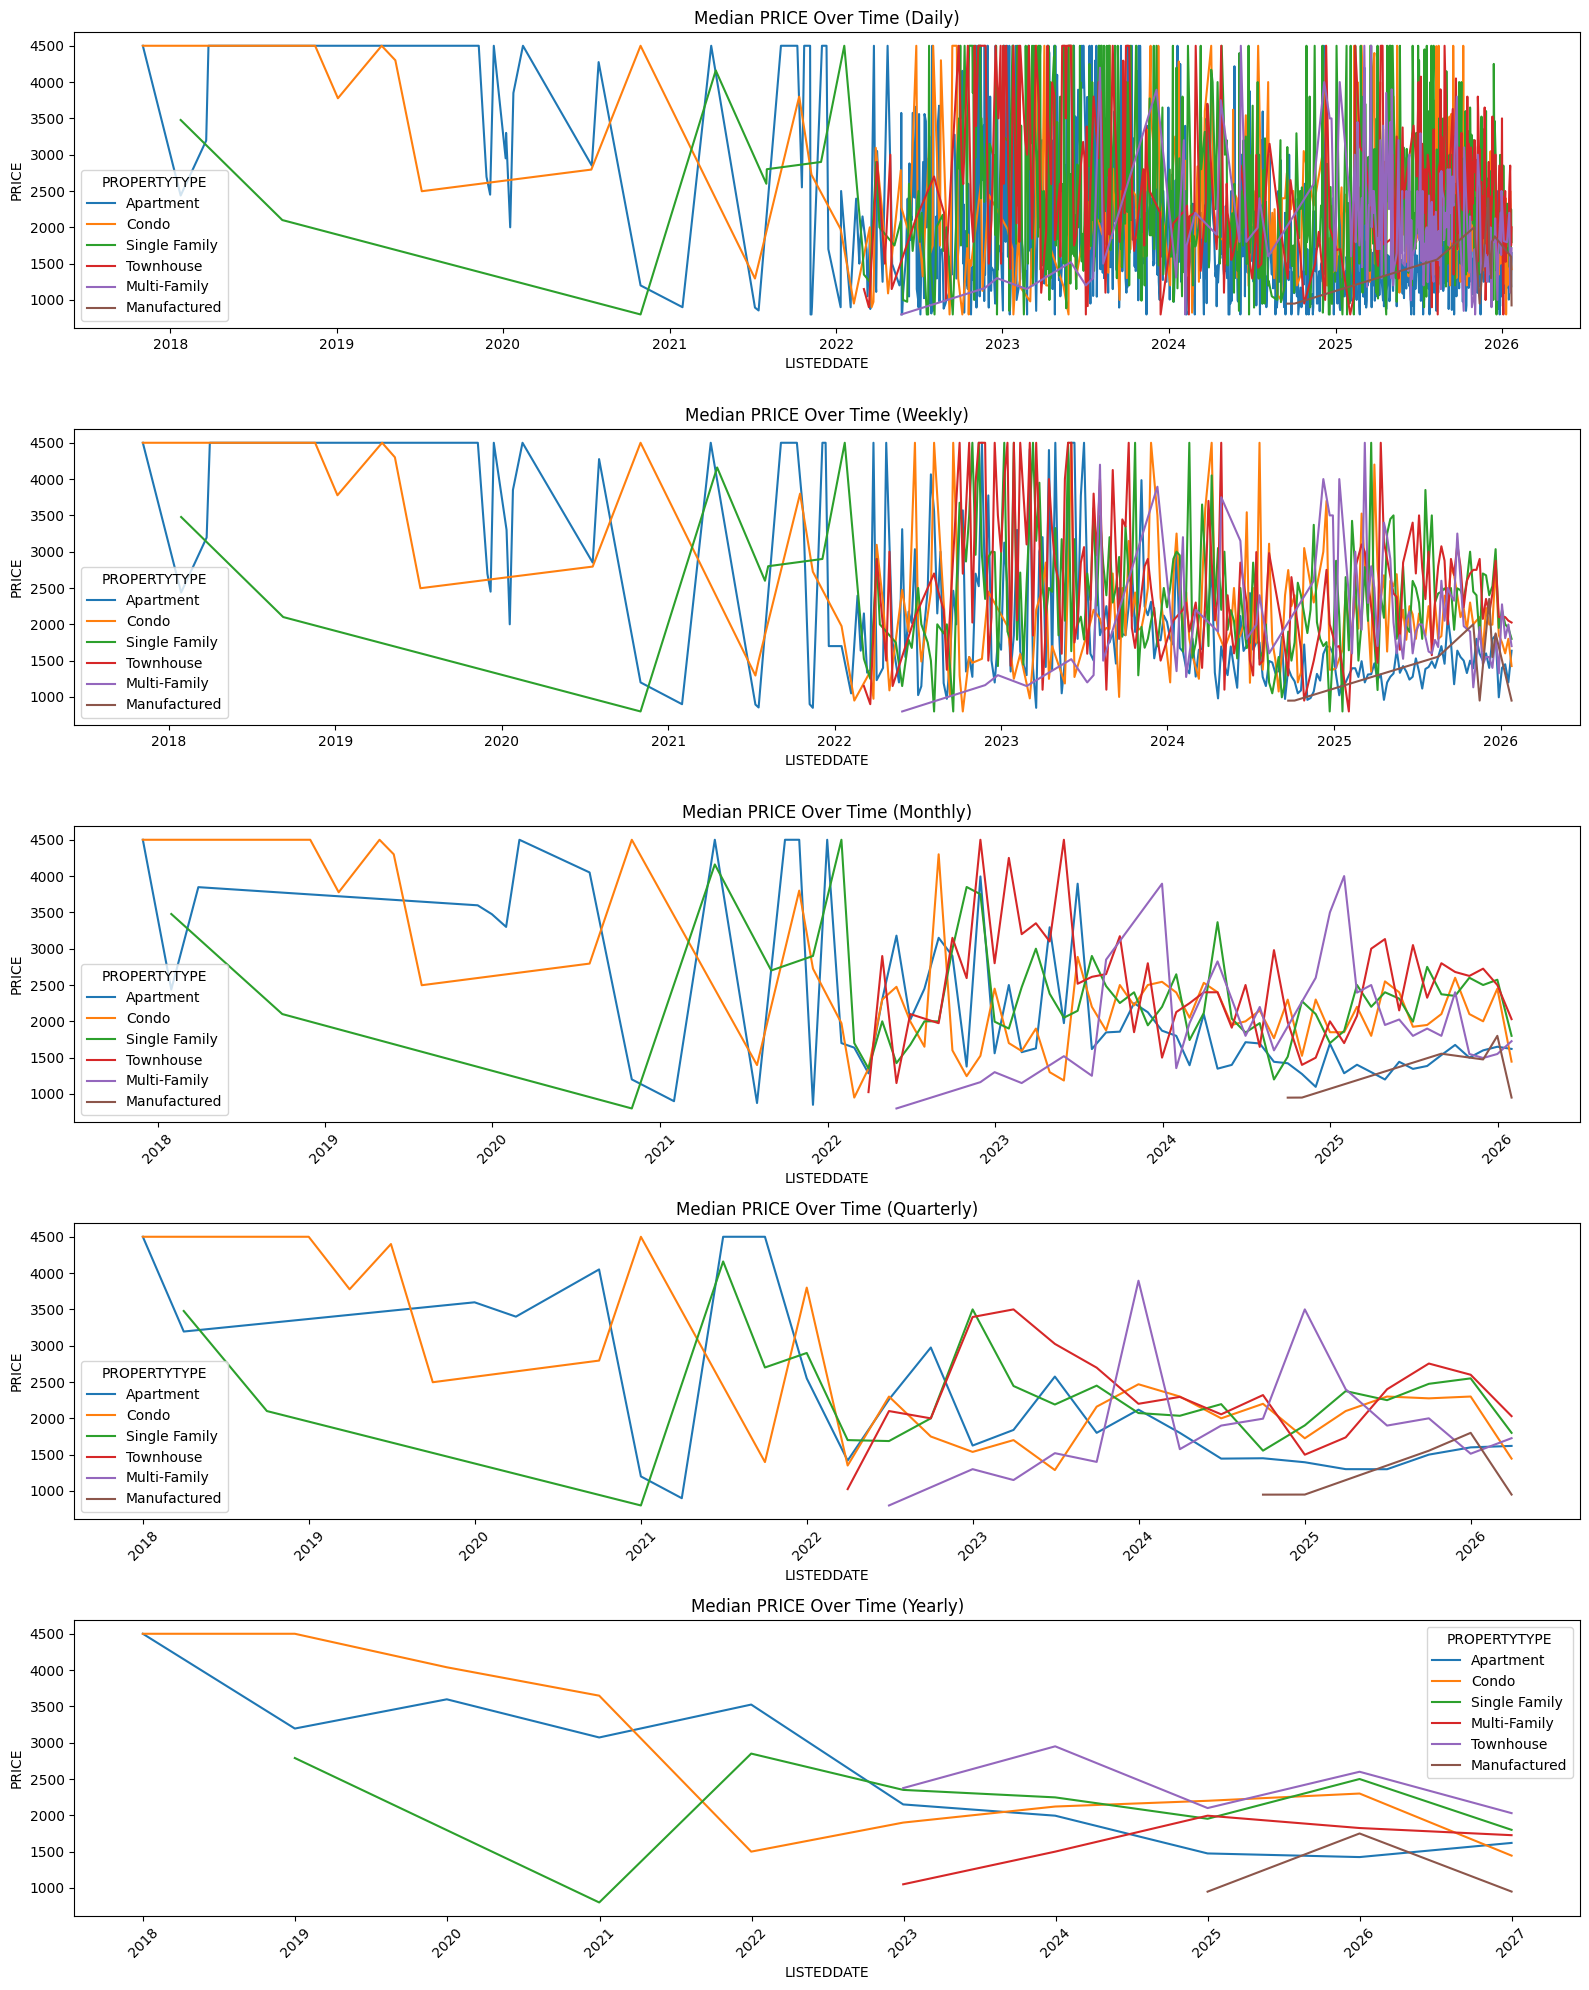

In [21]:
# LISTEDDATE, PRICE, PROPERTYTYPE
# Ensure datetime format
data["LISTEDDATE"] = pd.to_datetime(data["LISTEDDATE"], errors="coerce")

# Drop rows with missing necessary values
df = data.dropna(subset=["LISTEDDATE", "PRICE", "PROPERTYTYPE"]).copy()

# Create time-based groupings and aggregate by median PRICE
daily_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="D"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
weekly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="W"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
monthly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="M"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
quarterly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Q"), "PROPERTYTYPE"])["PRICE"].median().reset_index()
yearly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Y"), "PROPERTYTYPE"])["PRICE"].median().reset_index()

# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=False)

# Daily
sns.lineplot(data=daily_data, x="LISTEDDATE", y="PRICE", hue="PROPERTYTYPE", ax=axes[0])
axes[0].set_title("Median PRICE Over Time (Daily)")
axes[0].set_ylabel("PRICE")

# Weekly
sns.lineplot(data=weekly_data, x="LISTEDDATE", y="PRICE", hue="PROPERTYTYPE", ax=axes[1])
axes[1].set_title("Median PRICE Over Time (Weekly)")
axes[1].set_ylabel("PRICE")

# Monthly
sns.lineplot(data=monthly_data, x="LISTEDDATE", y="PRICE", hue="PROPERTYTYPE", ax=axes[2])
axes[2].set_title("Median PRICE Over Time (Monthly)")
axes[2].set_ylabel("PRICE")
axes[2].tick_params(axis='x', rotation=45)

# Quarterly
sns.lineplot(data=quarterly_data, x="LISTEDDATE", y="PRICE", hue="PROPERTYTYPE", ax=axes[3])
axes[3].set_title("Median PRICE Over Time (Quarterly)")
axes[3].set_ylabel("PRICE")
axes[3].tick_params(axis='x', rotation=45)

# Yearly
sns.lineplot(data=yearly_data, x="LISTEDDATE", y="PRICE", hue="PROPERTYTYPE", ax=axes[4])
axes[4].set_title("Median PRICE Over Time (Yearly)")
axes[4].set_ylabel("PRICE")
axes[4].tick_params(axis='x', rotation=45)

# Layout adjustment
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_27968\522918153.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="M"), "LISTINGTYPE"])["PRICE"].median().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_27968\522918153.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Q"), "LISTINGTYPE"])["PRICE"].median().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_27968\522918153.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Y"), "LISTINGTYPE"])["PRICE"].median().reset_index()


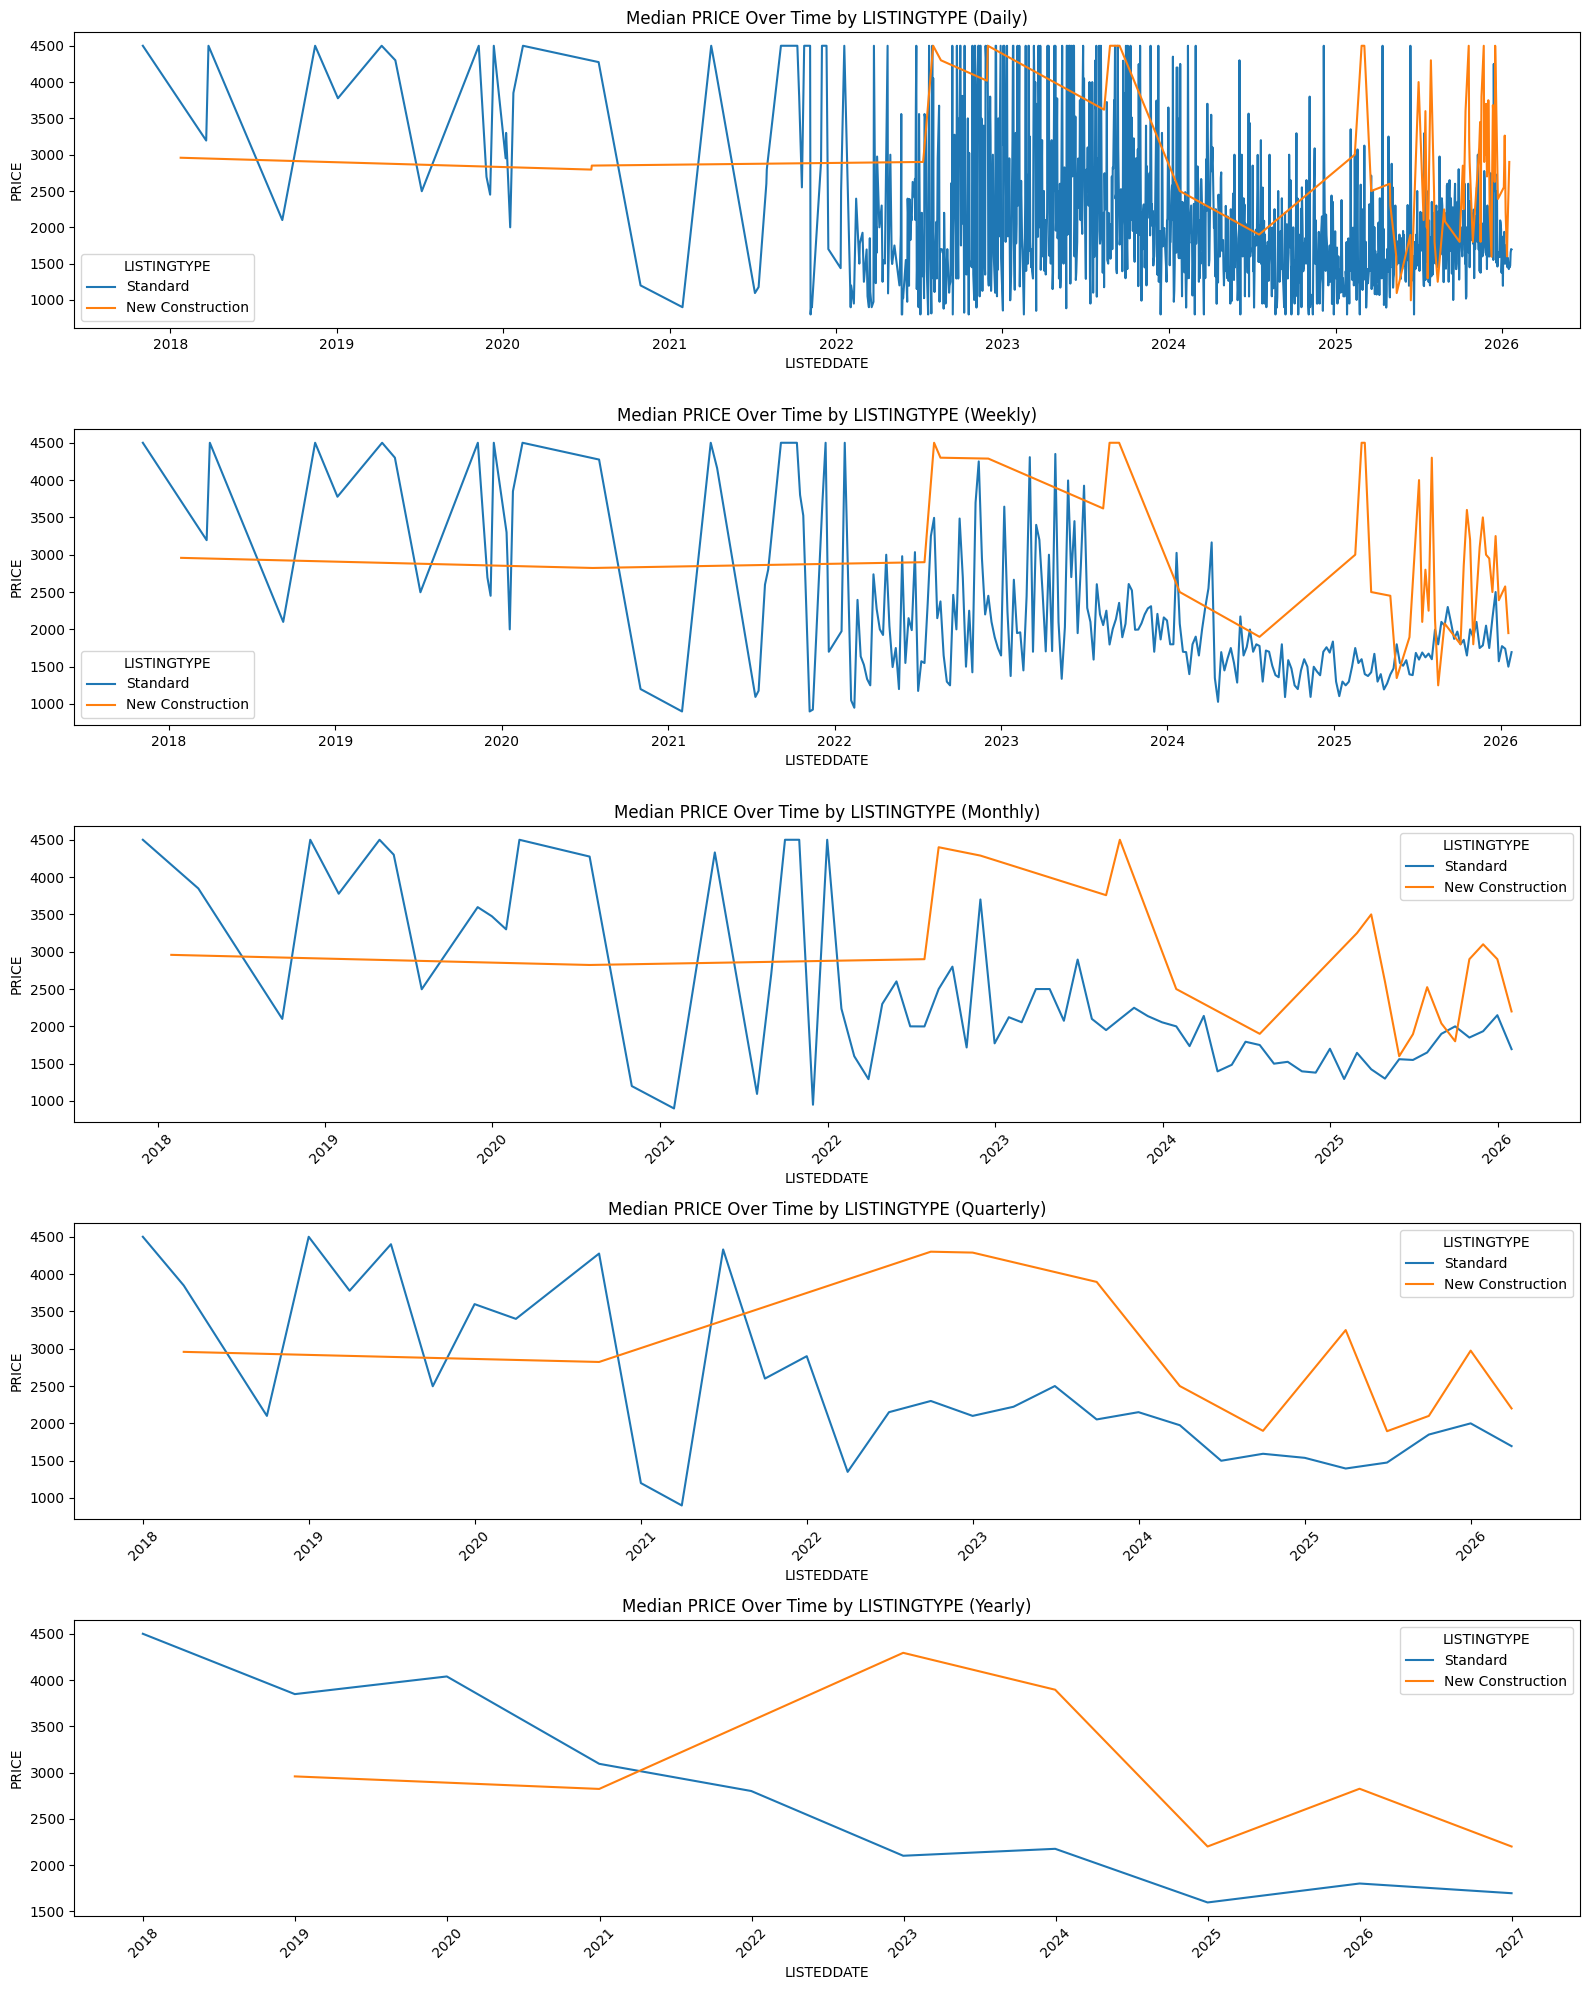

In [22]:
# LISTEDDATE, PRICE and LISTINGTYPE Analysis
# Ensure LISTEDDATE is datetime
data["LISTEDDATE"] = pd.to_datetime(data["LISTEDDATE"], errors="coerce")

# Drop missing key values
df = data.dropna(subset=["LISTEDDATE", "PRICE", "LISTINGTYPE"]).copy()

# Group and compute median PRICE by time frequency and LISTINGTYPE
daily_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="D"), "LISTINGTYPE"])["PRICE"].median().reset_index()
weekly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="W"), "LISTINGTYPE"])["PRICE"].median().reset_index()
monthly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="M"), "LISTINGTYPE"])["PRICE"].median().reset_index()
quarterly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Q"), "LISTINGTYPE"])["PRICE"].median().reset_index()
yearly_data = df.groupby([pd.Grouper(key="LISTEDDATE", freq="Y"), "LISTINGTYPE"])["PRICE"].median().reset_index()

# Set up 5-row subplot grid
fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=False)

# Daily
sns.lineplot(data=daily_data, x="LISTEDDATE", y="PRICE", hue="LISTINGTYPE", ax=axes[0])
axes[0].set_title("Median PRICE Over Time by LISTINGTYPE (Daily)")
axes[0].set_ylabel("PRICE")

# Weekly
sns.lineplot(data=weekly_data, x="LISTEDDATE", y="PRICE", hue="LISTINGTYPE", ax=axes[1])
axes[1].set_title("Median PRICE Over Time by LISTINGTYPE (Weekly)")
axes[1].set_ylabel("PRICE")

# Monthly
sns.lineplot(data=monthly_data, x="LISTEDDATE", y="PRICE", hue="LISTINGTYPE", ax=axes[2])
axes[2].set_title("Median PRICE Over Time by LISTINGTYPE (Monthly)")
axes[2].set_ylabel("PRICE")
axes[2].tick_params(axis='x', rotation=45)

# Quarterly
sns.lineplot(data=quarterly_data, x="LISTEDDATE", y="PRICE", hue="LISTINGTYPE", ax=axes[3])
axes[3].set_title("Median PRICE Over Time by LISTINGTYPE (Quarterly)")
axes[3].set_ylabel("PRICE")
axes[3].tick_params(axis='x', rotation=45)

# Yearly
sns.lineplot(data=yearly_data, x="LISTEDDATE", y="PRICE", hue="LISTINGTYPE", ax=axes[4])
axes[4].set_title("Median PRICE Over Time by LISTINGTYPE (Yearly)")
axes[4].set_ylabel("PRICE")
axes[4].tick_params(axis='x', rotation=45)

# Improve spacing
plt.tight_layout()
plt.show()


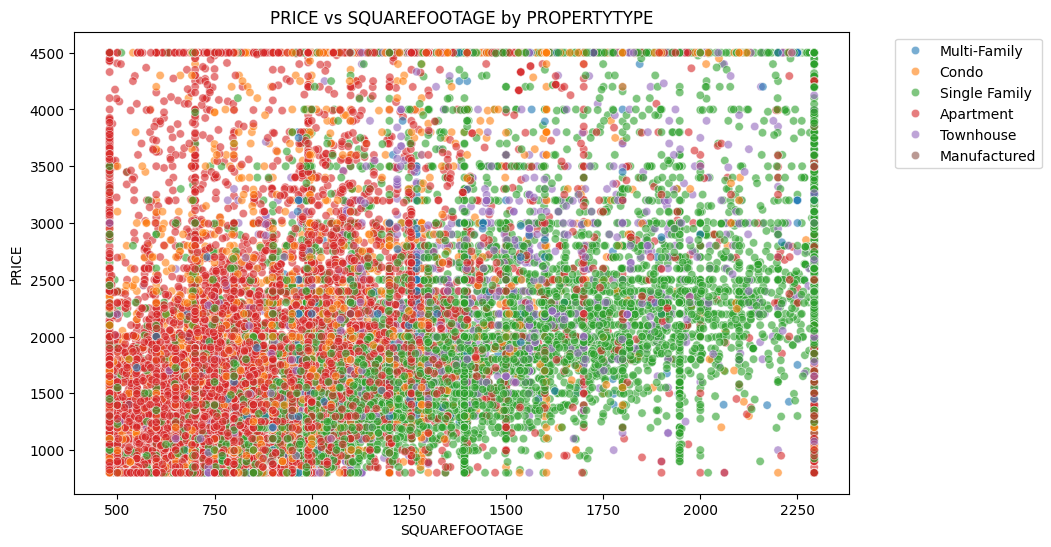

In [23]:
# SQUAREFOOTAGE vs PRICE by PROPERTYTYPE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SQUAREFOOTAGE', y='PRICE', hue='PROPERTYTYPE', data=df, alpha=0.6)
plt.title('PRICE vs SQUAREFOOTAGE by PROPERTYTYPE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


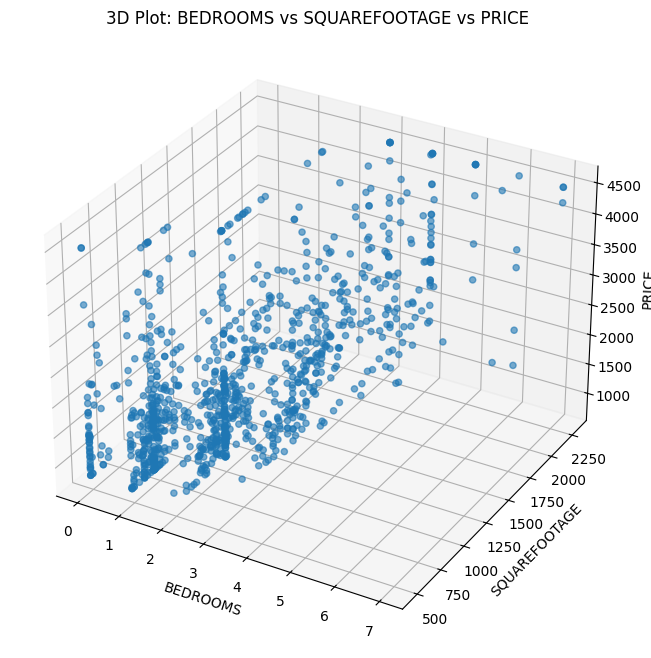

In [24]:
# 3D Plot: BEDROOMS, SQUAREFOOTAGE, PRICE


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sample_df = df.dropna(subset=['BEDROOMS', 'SQUAREFOOTAGE', 'PRICE']).sample(1000)

ax.scatter(sample_df['BEDROOMS'], sample_df['SQUAREFOOTAGE'], sample_df['PRICE'], alpha=0.6)
ax.set_xlabel('BEDROOMS')
ax.set_ylabel('SQUAREFOOTAGE')
ax.set_zlabel('PRICE')
plt.title('3D Plot: BEDROOMS vs SQUAREFOOTAGE vs PRICE')
plt.show()


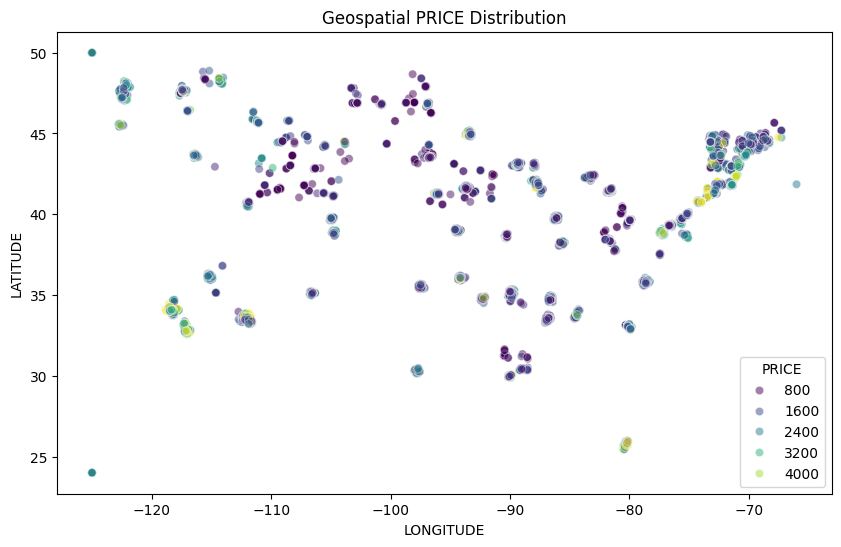

In [25]:
# PRICE Geo Distribution (LAT vs LONG)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='PRICE', data=df, palette='viridis', alpha=0.5)
plt.title('Geospatial PRICE Distribution')
plt.show()


**ANALYSIS**

1: Median PRICE Over Time by PROPERTYTYPE

a. Daily/Weekly: Too noisy for practical insight due to sparse, overlapping lines and sampling variation.

b. Monthly to Yearly: Downward trend from 2021 onwards is clear across most property types. Townhouses and Condos remain relatively high-value segments. Manufactured homes show lowest and flattest median pricing, consistent with affordability positioning. 

The decline in most types mirrors macroeconomic or supply-driven market cooling.

2: Median PRICE Over Time by LISTINGTYPE: 

a. Standard listings dominate in count and show a clear, steady decline in median prices from 2018 to 2026.

b. New Constructions hold a price premium and show price stability, especially from 2022 onward.

c. The price gap between New vs Standard listings widens post-2021, suggesting increasing buyer willingness to pay for newer stock.

In modeling or marketing, treat New Construction as a distinct premium class.

3: PRICE vs SQUAREFOOTAGE by PROPERTYTYPE

a. Price generally increases with square footage, but Apartments & Manufactured homes dominate the low-price, low-size quadrant. Single Family and Townhouses span higher square footage with broader price ranges.

b. Manufactured homes are price-capped and squeezed tightly in a low-cost zone.

c. Condos and Multi-Family have overlap zones but show slightly tighter pricing spread.

Square footage interacts differently with price across property types—model interactions explicitly.

4: 3D Plot – BEDROOMS vs SQUAREFOOTAGE vs PRICE

a. Price increases with both dimensions (bedrooms and square footage).

b. Densest clusters: 2–4 bedrooms, 800–1800 sq. ft, Price range: ~$1200–$3000

c. High-price outliers occur in 5+ bedrooms and 2000+ sq. ft homes

Use both variables together in predictive models. Consider interactions or non-linear terms.

5: Geospatial PRICE Distribution (LATITUDE / LONGITUDE)

a. Higher prices cluster in the northeast corridor, southern California, and select western markets.

b. Central, southern, and inland markets skew lower in price.

c. Coastal premium is clearly visible.

Geography (city, ZIP, coordinates) is a strong determinant of price. Geospatial features or clustering should be used in modeling.

**Summary:** 

Market Direction: Median listing prices are declining over time across nearly all categories.

New Construction is increasingly premium and less volatile.

Size and features (bedrooms, sqft) strongly predict price.

Townhouses and Single Family homes remain high-value.

Apartments & Manufactured homes target lower price segments.

Regional variation is stark, with coastal/urban areas commanding premiums.

**Recommendations**

Investors -	Prioritize New Constructions and Townhouses in premium regions (e.g., Northeast, West Coast) for higher and more stable returns.

Developers - Build toward the market sweet spot: 3–4 bedrooms, 1200–1800 sqft. Emphasize quality and location.

Sellers	- For Standard listings, act quickly to avoid further depreciation in a declining market. Highlight unique features to differentiate.

Buyers	- Look for value in mid-size homes in non-coastal metros. Opportunity exists as prices fall across the board.

Modeling/Data Teams	- Use interaction terms (e.g., BEDROOMS * SQUAREFOOTAGE) and geospatial clustering. Apply log(price) or winsorization to stabilize variance.

Policy Makers - Coastal premiums and shrinking affordability in urban cores may justify intervention. Consider regional affordability monitoring.

**Correlation Matrix**

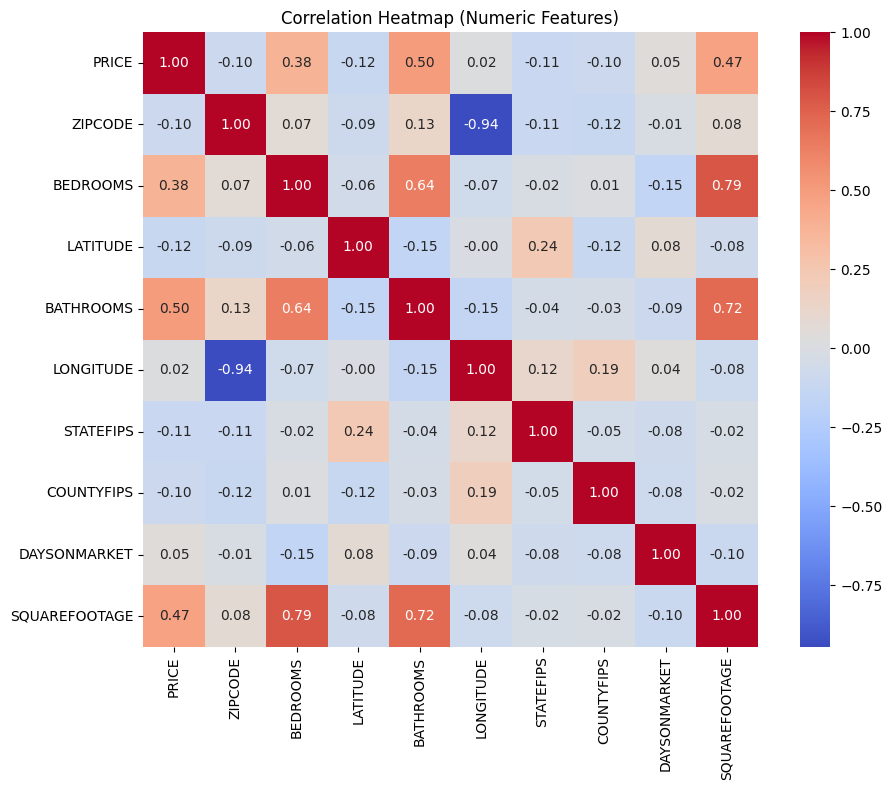

In [26]:
# Correlation heatmap (numeric only)
corr = data[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


**Correlation Matrix Summary**

a. PRICE relationships: PRICE vs BATHROOMS (0.50), PRICE vs SQUAREFOOTAGE (0.47) and PRICE vs BEDROOMS (0.38). These are the three strongest numeric drivers of price, reinforcing the size/space dimension as the core pricing signal. Bathrooms slightly outperform the others.

b. Internal Size Feature Correlations: BEDROOMS vs SQUAREFOOTAGE (0.79), BATHROOMS vs SQUAREFOOTAGE (0.72) and BEDROOMS vs BATHROOMS (0.64). There are strong multicollinearity between these features because they all describe home size/capacity, so redundant use may hurt linear models. Consider dimension reduction or feature selection.

c. Location Features: ZIPCODE vs LONGITUDE (-0.94). This is an encoding artifact, not a meaningful spatial relationship. ZIPs increment roughly east to west, hence the near-perfect negative correlation. LATITUDE / LONGITUDE vs PRICE relationship is Weak (−0.12 and +0.02). STATEFIPS / COUNTYFIPS vs PRICE is also weak (−0.11, −0.10). Raw geographic coordinates do not explain much variation in price. Neighborhood effects likely exist but require more sophisticated spatial features, like ZIP or city-level medians, clusters, or engineered distances.

d. DAYSONMARKET: PRICE vs DAYSONMARKET (0.05) is a very weak linear relationship but may reflect listings removed quickly if priced well (non-linear), market-specific dynamics, and still useful in advanced models via: Log transform: log1p(DAYSONMARKET), interaction terms: e.g., DOM × PROPERTYTYPE

e. ZIPCODE, STATEFIPS, COUNTYFIPS: All show weak correlations with PRICE or other features. Useful only as location labels, not numeric predictors.

**Recommendations**

1. Feature Engineering: Use SQUAREFOOTAGE + BATHROOMS as core size indicators. Optionally exclude BEDROOMS or apply dimensionality reduction (e.g., PCA) to address multicollinearity.

2. Location Modeling: Avoid raw numeric use of ZIPCODE, STATEFIPS, COUNTYFIPS and use as categorical features or encode via: Target/mean encoding, and Cluster/group-based features (e.g., ZIP-level median price).  LATITUDE & LONGITUDE can  try Geo-clusters (e.g., k-means or DBSCAN), distance to city center, and combine into “region” categories

3. Modeling Implications: 

Linear Models - (OLS, Ridge, Lasso)	Handle multicollinearity with regularization or feature reduction.

Tree-Based Models (XGBoost, LightGBM)	- Naturally handle redundant features. Excellent choice for this dataset.

Neural Nets	- Benefit from engineered features and normalized numeric inputs.

Spatial Models	- Consider if detailed location analysis is core to your goal.

**Conclusion**

This correlation analysis supportsfindings:

Home size (via square footage, bathrooms, bedrooms) remains the dominant factor influencing price.

Geographic factors, though crucial in practice, must be modeled through categorical or engineered features.

Multicollinearity is significant among size indicators and must be accounted for in linear settings.

Use flexible models (like tree-based or regularized ones) to handle the interplay between these numeric and categorical drivers.

**CONCLUSION**

**Univariate Analysis Highlights**

PRICE is strongly right-skewed due to luxury listings. Winsorization or log transformation helps reduce modeling bias while preserving meaningful high-end variation.

ZIPCODE, LATITUDE, LONGITUDE confirm the dataset covers geographically diverse listings, with clear ZIP and city-level clusters that are ideal for regional segmentation or spatial modeling.

BEDROOMS and BATHROOMS are concentrated around 2–3, reflecting the median housing stock. Higher counts are rare but valid and represent luxury segments worth modeling separately.

SQUAREFOOTAGE is right-skewed and highly correlated with BEDROOMS and BATHROOMS, indicating redundant size information. Use this carefully in linear models to avoid multicollinearity.

DAYSONMARKET shows a spike at low values and a long tail, indicating that most listings move quickly. Log transformation is recommended to reduce skew for predictive modeling.

STATEFIPS, ZIPCODE, COUNTYFIPS are better treated as categorical location identifiers — not numeric inputs — for grouping, segmentation, or spatial feature engineering.

**Bivariate & Multivariate Analysis Highlights**

PROPERTYTYPE is a strong price discriminator: Townhouses and Condos command higher median prices. Manufactured homes consistently rank lowest. These patterns persist across time and size, making this feature highly valuable.

LISTINGTYPE shows a clear price gap: New Construction listings maintain a premium and show stable prices over time. 
However, their volume is low compared to Standard listings, limiting standalone predictive power. 

PRICE correlates most strongly with SQUAREFOOTAGE (~0.47), followed by BATHROOMS (~0.50) and BEDROOMS (~0.38). These features carry overlapping size information and are central to modeling price.

Geospatial trends confirm that coastal and metro areas (e.g., Northeast, West Coast) command premium prices, while inland regions trend lower — ZIP or city granularity is essential.

3D plots and scatterplots (PRICE vs SQUAREFOOTAGE vs BEDROOMS) confirm that price increases with property size and features, especially between 2–4 beds and 800–1800 sq ft.

Time-based analysis shows: Overall price decline from 2018 to 2026, particularly for Standard listings. New Construction prices remain relatively stable. Weekly/daily volatility masks patterns; while monthly+ aggregation is best for trend detection.

**Recommendations**

1. Focus on ZIP/City-Level Market Segmentation: National and state-level averages obscure true market signals due to sample caps. Build interactive dashboards or models at ZIP/city level for actionable insights on pricing, DOM, and listing volume.

2. Segment by PROPERTYTYPE for Modeling: PROPERTYTYPE is highly predictive of price, behavior, and temporal trends. 
Exclude or consolidate low-volume categories (e.g., Manufactured, Multi-Family) to reduce noise and improve model generalizability.

3. LISTINGTYPE : LISTINGTYPE has clear price gaps, but imbalanced volume (Standard > New Construction) means it should be used with caution. Consider treating it as a secondary feature or segment analysis variable.

4. Transform Skewed Features: Apply log or power transforms to PRICE, SQUAREFOOTAGE, BATHROOMS and DAYSONMARKET. This improves model performance and helps meet linearity assumptions in regression models.

5. Build Feature-Rich, Multivariate Models: Prioritize SQUAREFOOTAGE, BATHROOMS, BEDROOMS, and PROPERTYTYPE. Add location via categorical ZIPCODE or engineered geo features (e.g., ZIP median price, cluster ID, distance-to-center). Use interaction terms like BEDROOMS × SQUAREFOOTAGE for improved precision in mid-to-high tier pricing.

6. Avoid Misusing Location Features: Treat ZIPCODE, STATEFIPS, COUNTYFIPS as categorical, not numeric. Do not use raw LAT/LONG directly; instead, cluster or encode location features. Watch for encoding artifacts like the strong ZIP-LONGITUDE correlation (–0.94).

7. Handle Multicollinearity in Size Features: BEDROOMS, BATHROOMS, and SQUAREFOOTAGE are highly correlated. Use regularized linear models (Ridge, Lasso), Tree-based models (XGBoost, LightGBM) which handle redundancy well

8. Account for Sampling Limits and External Enrichment: The dataset shows caps on state-level volume (~500/state)  and this may bias national trends. Consider joining external sources: ZIP-level rent, household income, population density, or demand indicators.

9. Deploy Live Market Monitoring: Develop real-time dashboards to track Price trends, Inventory levels, DOM by region/property type and enable drill-downs by ZIP, time period, and property type for stakeholders to act on timely trends.